# Load package

In [1]:
#TODO compress Crystal Calculator 
#TODO add thickness

## Load crystal package

In [162]:
"""
Author: Juanjuan Huang, Advanced Photon Source
juanjuan.huang@anl.gov
Copyright © 2023, UChicago Argonne, LLC
"""


import numpy as np
import datetime
import matplotlib.pyplot as plt
from xoppylib.crystals.tools import bragg_calc2, run_diff_pat
import xraylib
from dabax.dabax_xraylib import DabaxXraylib
import os
import glob
import re

def date_today():
    return datetime.datetime.today().strftime('%Y%m%d')

def time_now():
    return datetime.datetime.now().strftime('%H%M')


def fwhm_calc(x, y, plot = True, printit = True):
    """
    Calculate the Full Width at Half Maximum (FWHM) of a dataset.
    
    Parameters:
        x (array): The x values of the dataset.
        y (array): The y values of the dataset.
        
    Returns:
        The FWHM of the dataset.
    """
    # Find the maximum value and location
    max_y = np.max(y)
    max_x = x[np.argmax(y)]

    # Find the half-maximum points
    half_max = max_y / 2
    greater_than_half = y > half_max
    half_max_x1 = np.min(x[greater_than_half])
    half_max_x2 = np.max(x[greater_than_half])

    # Calculate the FWHM
    fwhm = half_max_x2 - half_max_x1

    # Plot the dataset and the half-maximum points
    if plot:
        random_color = np.random.rand(3,)
        plt.plot(x, y, ls = ":", color=random_color, alpha=0.2)
        plt.axvline(half_max_x1, color=random_color, alpha=0.6, label=f'Half-Max: {fwhm:.2f}')
        plt.axvline(half_max_x2, color=random_color, alpha=0.6,)
        plt.legend()
    if printit:
       # Return the FWHM
       print("FWHM is %.2f"%fwhm)
    return fwhm

def reflectivity_data_get(data_lst, plot = True, fontsize = 14, **kwargs):
    FWHM_all_p = []
    FWHM_all_s = []
    R_all = []

    for data_lst_i in data_lst:
        R_all.append(int(re.findall(r'\d+', data_lst_i)[-2]))
        data = np.loadtxt(data_lst_i)
        if plot:
            plt.figure()
            title = data_lst_i.split("/")[-1][:-3]
            plt.plot(data[:,0], data[:,-1], label='s-polarization', **kwargs)
            plt.plot(data[:,0], data[:,-2], label='p-polarization', **kwargs)
            plt.ylabel('Crystal reflectivity', fontsize = fontsize)
            plt.xlabel("$\\theta - \\theta_B$ [$\mu$rad]", fontsize = fontsize)
            plt.xticks(fontsize = fontsize)
            plt.yticks(fontsize = fontsize)
            plt.title(title)
            plt.legend(fontsize = fontsize)
        FWHM_all_p.append(fwhm_calc(data[:,0], data[:,-2], plot=plot, printit=plot))
        FWHM_all_s.append(fwhm_calc(data[:,0], data[:,-1], plot=plot, printit=plot))

    
    FWHM_all_p = np.asarray(FWHM_all_p)
    FWHM_all_s = np.asarray(FWHM_all_s)
    R_all = np.asarray(R_all)

    return R_all, FWHM_all_p, FWHM_all_s 


def get_Bragg_resolution(hkl=[1,1,1], E=8333, scanfrom=-200, scanto=100, R_m=150, scanpnts=300):
    bragg_dictionary = bragg_calc2(
    descriptor = "Si",
    hh         = hkl[0], 
    kk         = hkl[1], 
    ll         = hkl[2], 
    temper     = 1.0, 
    emin       = E-100,
    emax       = E+100,
    estep      = 0.4,
    ANISO_SEL  = 0,
    fileout    = "xcrystal.bra",
    do_not_prototype = 0,  # 0=use site groups (recommended), 1=use all individual sites
    verbose = False,
    material_constants_library = xraylib,
    )

    # run external (fortran) diff_pat (note that some parameters may not be used)
    run_diff_pat( 
        bragg_dictionary,
        preprocessor_file  = "xcrystal.bra",
        descriptor         = "Si",
        MOSAIC             = 2, 
        GEOMETRY           = 0, 
        SCAN               = 2, 
        UNIT               = 1, 
        SCANFROM           = scanfrom, 
        SCANTO             = scanto, 
        SCANPOINTS         = scanpnts, 
        ENERGY             = E, 
        ASYMMETRY_ANGLE    = 0.0, 
        THICKNESS          = 0.02, # cm
        MOSAIC_FWHM        = 0.1, 
        RSAG               = 1000000000.0, 
        RMER               = R_m, 
        ANISOTROPY         = 0, 
        POISSON            = 0.22, 
        CUT                = "2 -1 -1 ; 1 1 1 ; 0 0 0",
        FILECOMPLIANCE     = "mycompliance.dat", 
        )
    data_i = np.loadtxt("diff_pat.dat", skiprows=5)
    # noinspection PyBroadException
    try:
        os.mkdir("Crystal_reflectivity")
    except:
        pass

    save_name = "Crystal_reflectivity/Si%d%d%d_Rm%03dcm_%deV.dat"%(hkl[0], hkl[1], hkl[2], R_m, E)
    np.savetxt(save_name, data_i)
    return save_name


class Crystal(object):

    def __init__(self, energy, hkl = None, p = 0, crystal = 'Si', divergence = 2/1000., R = 1e8, d_ML = None):
        """
        Creat a Crystal class

        Parameters
        ----------
        energy : floats
        hkl : list, default: [1,1,1]
        p : floats, default: 0
            Source-to-crystal distance [m]
        crystal: str, default: 'Si'
            Or 'Ge', 'ML'(multilayer), for ML choice, please specify d_ML
        divergence: floats, default: 2/1000.
            Full divergence of X-ray (NOT half divergence!)
        R: int, default : 1e8
        d_ML: floats
            d-spacing of multilayer [angstrom]


      """
        self.energy = energy
        self.wavelength = 12.3984428/energy # in angstrom
        self.hkl = hkl
        self.crystal = crystal
        self.divergence = divergence
        self.p = p
        self.R = R
        if self.crystal == 'Si':
            self.lattice_cons = 5.431
        elif self.crystal == 'Ge':
            self.lattice_cons = 5.65
        elif self.crystal == 'ML':
            self.d = d_ML # in angstrom
        self.printlst = {'00_header_top': '='*50,
                         '01_Energy_hkl':'Energy is %.2f KeV and %s(hkl)is %s'%(self.energy,self.crystal, str(self.hkl)),
                         '02_header_bottom':'='*50,
                        }
    @property
    def theta0(self):
        if self.crystal != 'ML':
            self.d = self.lattice_cons/np.sqrt(self.hkl[0]**2 + self.hkl[1]**2 + self.hkl[2]**2) # in angstrom
        theta0 = np.arcsin(self.wavelength/(2.*self.d))
        self.printlst['03_theta0'] = 'theta0 : %.3f rad, %.2f degree'%(theta0, np.rad2deg(theta0))
        return theta0

    @property
    def energy_spread_flat(self):
        theta_Emin = self.theta0 + self.divergence/2.
        theta_Emax = self.theta0 - self.divergence/2.

        self.E_min = 12.39847/(2 * self.d * np.sin(theta_Emin))
        self.E_max = 12.39847/(2 * self.d * np.sin(theta_Emax))

        energy_spread = self.energy * self.divergence / np.tan(self.theta0)
        self.printlst['04_energy_spread_flat'] = 'Energy spread (flat crystal): %.2f eV'%(energy_spread*1000)
        return energy_spread, [theta_Emin, theta_Emax]

    def det2cen_calc(self, dety=None, det2crys_d=None):
        """
        dy: distance of detector along y-direction (X-ray propagation direction), in mm
        """
        if dety is None:
            dety = det2crys_d * np.cos(2*self.theta0)
        self.d_det2cen = dety * np.tan(2 * self.theta0)
        self.printlst['06_det2cen_distance'] = 'detector position to the center is %.3f m'%(self.d_det2cen)
        return self.d_det2cen

    def angle_to_energy_spread_calc(self, delta_theta):
        deltaE = delta_theta *  1/np.tan(self.theta0) * self.energy
        # print('Energy spread for %.f microrad is: %.2f eV'%(delta_theta*1e6, deltaE*1000))
        return deltaE

    @property
    def beam_size(self):
        beam_size = 2 * self.p * 1000 * np.tan(self.divergence/2) # + 50/1000 # in mm
        self.printlst['05_beam_size_transverse'] = 'Transverse beam size at a distance of %.3f m is %.3f mm'%(self.p, beam_size)
        return beam_size

    def type_writer(self, curvature = False, crystal_rotation = False, sort = True):
        if sort:
            printlst = sorted(self.printlst)
        else:
            printlst = self.printlst
        for items in printlst:
            print(self.printlst[items])


class Laue_Crystal(Crystal):

    def __init__(self,  energy, hkl=[1,1,1], p=0, crystal='Si', divergence=2/1000., R=1e8,
                 surface_hkl=[1,0,0], Poisson_ratio=0.22, T = 200 * 1e-6,  condition = 'lower', assy_angle = None):
        super().__init__(energy, hkl, p, crystal, divergence, R)
        self.Poisson_ratio = Poisson_ratio
        self.T = T
        self.condition = condition
        self.printlst['00_header_top_01'] = '-' * 19 + 'LAUE CRYSTAL' + '-'*19
        
        if assy_angle is None:
            plane = np.array(self.hkl)
            normal = np.array(surface_hkl)
            self.assy_angle = np.pi/2 - np.arccos(np.dot(plane,normal)/np.linalg.norm(plane)/np.linalg.norm(normal))
            self.printlst['Laue01_assymetry_cut'] = 'Assymetric cut is : %.2f degree'%np.rad2deg(self.assy_angle)
        else:
            self.assy_angle = assy_angle

    @property
    def crystal_rotation(self):
        if self.condition == 'upper':
            crystal_rotation = 0.5 * np.pi - (self.assy_angle + self.theta0)
        elif self.condition == 'lower':
            crystal_rotation = 0.5 * np.pi - (self.assy_angle - self.theta0)
        self.printlst['Laue02_crystal_rotation'] = 'crystal rotation: %s case,  %.6f rad, %.3f degree \n'%(self.condition, crystal_rotation, np.rad2deg(crystal_rotation))
        return crystal_rotation

    @property
    def foot_print(self):
        return self.beam_size / np.sin(self.crystal_rotation) # in mm

    def energy_spread_bent_calc(self):
        delta_bent_crystal = self.foot_print/1000/self.R # in radians
        delta_theta = self.divergence + delta_bent_crystal # here should use minus
        deltaE = delta_theta *  1/np.tan(self.theta0) * self.energy
        self.energy_spread_bent = deltaE
        self.delta_theta = delta_theta
        self.printlst['Laue03_energy_spread_bent'] = 'The energy spread for the crystal with bending radius of %.2f is %.2f eV'%(self.R, deltaE*1000)
        return deltaE

    @property
    def energy_spread_bent_esrf(self):
        delta_theta= self.beam_size/1000/np.cos(self.theta0)/2 * (1/self.p - self.f_g) #beamsize in mm, this is only true for symmetric crystal
        deltaE = delta_theta *  1/np.tan(self.theta0) * self.energy
        self.printlst['Laue04_energy_spread_bent_esrf'] = 'ESRF energy spread for the crystal with bending radius of %.2f is %.2f eV \n'%(self.R, deltaE*1000)
        return deltaE

    def curvature_calc(self, exp_spread = 0):
        self.diff_spread = self.energy_spread_flat[0] - exp_spread
        self.diff_delta = self.diff_spread * np.tan(self.theta0) / self.energy
        self.crys_curvature = self.foot_print / self.diff_delta / 1000 # in m
        self.printlst['Laue05_01_diff_spread'] = '-'*50 + '\n'+'difference between exp and theoretical is: %f eV'%(self.diff_spread* 1000)
        self.printlst['Laue05_02_diff_delta'] = 'curvature induced delta is: %f mrad'%(self.diff_delta * 1000)
        self.printlst['Laue05_03_beam_size'] = 'Beam size on the crystal at distance of %.2f m is: %.2f mm'%(self.p, self.beam_size)
        self.printlst['Laue05_04_foot_print'] = 'footprint at rotation angle %.2f is: %.2f cm'%(self.crystal_rotation, self.foot_print)
        self.printlst['Laue05_05_crys_curvature'] = 'Crystal curvature is: %.3f m'%self.crys_curvature +'\n'+'-'*50
        return self.crys_curvature

    def single_ray_focus_calc(self):
        if self.condition == 'upper':
            theta0 = self.theta0
        elif self.condition == 'lower':
            theta0 = - self.theta0
        self.f_p = self.R * np.sin(2 * theta0)/(2 * np.sin(self.assy_angle + theta0) + (1+self.Poisson_ratio) * np.sin(2*self.assy_angle) * np.cos(self.assy_angle + theta0))
        print()
        self.printlst['Laue06_single_ray_focus'] = 'Single-ray focus: %.5f'%self.f_p
        return self.f_p

    def geometric_focus_calc(self, assy_angle = None):
        if self.condition == 'upper':
            theta0 = self.theta0
        elif self.condition == 'lower':
            theta0 = - self.theta0

        if assy_angle is None:
            assy_angle = self.assy_angle
        self.f_g = np.cos(assy_angle - theta0)/(2/self.R + np.cos(assy_angle + theta0)/self.p)
        self.printlst['Laue07_01_geometric_focus'] = 'Geometric focus: %.5f'%self.f_g
        self.printlst['Laue07_02_geometric_focus'] = 'Geometric along incident ray direction: %.5f'%(self.f_g * np.cos(2 * self.theta0))
        return self.f_g

    def Bragg_size_calc(self, det2crys_d):
        if self.condition == 'upper':
            theta0 = self.theta0
        elif self.condition == 'lower':
            theta0 = - self.theta0

        # delta_bent_crystal = self.foot_print/1000/self.R
        # self.Laue_size = self.beam_size/1000 - ((det2crys_d - self.beam_size/1000/2 * 1/np.tan(self.crystal_rotation)) * np.tan(2*self.theta0 - 0.5* self.divergence+ delta_bent_crystal)) + ((det2crys_d + self.beam_size/1000/2 * 1/np.tan(self.crystal_rotation)) * np.tan(2*self.theta0 + 0.5* self.divergence - delta_bent_crystal))
        # vertical_x1 =  self.beam_size/1000/2 + (det2crys_d + self.beam_size/1000/2 * 1/np.tan(self.crystal_rotation)) * np.tan(2*self.theta0 - self.divergence/2)
        # vertical_x2 =  -self.beam_size/1000/2 + (det2crys_d - self.beam_size/1000/2 * 1/np.tan(self.crystal_rotation)) * np.tan(2*self.theta0 + self.divergence/2)
        # self.Laue_size = vertical_x1 - vertical_x2
        # print(vertical_x1)
        # print(vertical_x2)
        self.det2crys_d = det2crys_d
        self.det_position = det2crys_d * np.tan(2*self.theta0)
        # print('middle ray position:', det2crys_d * np.tan(2*self.theta0))
        exit_beam_size_vertical = (np.cos(self.assy_angle - theta0)/np.cos(2 * theta0)) * self.foot_print/1000
        #print(self.foot_print)
        #print(np.cos(self.assy_angle + theta0)/np.cos(2 * theta0))
        #print(self.exit_beam_size_vertical)
        self.Laue_size = (self.f_g - det2crys_d)/self.f_g * exit_beam_size_vertical
        self.Laue_size_vertical = self.Laue_size / np.cos(2 * theta0)

        self.printlst['Laue08_Laus_size'] = 'Laue beam size on the detector:%.2f mm \n'%(self.Laue_size*1000)
        return self.Laue_size, self.Laue_size_vertical

    def magic_condition_calc(self):
        if self.condition == 'upper':
            theta0 = self.theta0
        elif self.condition == 'lower':
            theta0 = - self.theta0
        magic_coeff = (2+self.Poisson_ratio) * np.tan(self.assy_angle) + self.Poisson_ratio * np.tan(theta0) * np.tan(self.assy_angle)**2 + np.tan(self.assy_angle)**2 * np.tan(self.assy_angle) -np.tan(theta0)
        self.printlst['Laue09_magic_condition_coff'] = 'Magic condition coeff:%.2f \n'%(magic_coeff)
        return magic_coeff

    def Borrmann_calc(self):
        if self.condition == 'upper':
            theta0 = self.theta0
        elif self.condition == 'lower':
            theta0 = - self.theta0
        # thesis
        Borrmann_angle = (self.T/self.R) * (np.tan(self.assy_angle + theta0) + np.sin(self.assy_angle) * np.cos(self.assy_angle) * (1+self.Poisson_ratio) - np.tan(theta0)*(np.cos(self.assy_angle)**2 - self.Poisson_ratio * np.sin(self.assy_angle)**2))
        # Borrmann_angle = (self.T/self.R) * (np.tan(self.assy_angle - theta0) + np.sin(self.assy_angle) * np.cos(self.assy_angle) * (1+self.Poisson_ratio) + np.tan(theta0)*(np.cos(self.assy_angle)**2 - self.Poisson_ratio * np.sin(self.assy_angle)**2))
        self.printlst['Laue10_01_Borrmann_fan'] = 'Borrmann fan:%.3f microrad'%(Borrmann_angle*1e6)
        self.printlst['Laue10_02_Borrmann_fan'] = 'Corresponding energy spread:%.3f eV'%(self.energy_resolution_calc(Borrmann_angle))
        return Borrmann_angle

    def Borrmann_flat_calc(self):
        Borrmann_width =  2*self.T*np.sin(self.theta0) # in meter
        self.printlst['Laue10_00_Borrmann_fan'] = 'Borrmann fan (flat_crystal):%.3f microm'%(Borrmann_width*1e6)
        #deltaE = self.energy_resolution_calc(Borrmann_angle)
        return Borrmann_width

    def Borrmann_bent_calc(self):
        if self.condition == 'upper':
            theta0 = self.theta0
        elif self.condition == 'lower':
            theta0 = - self.theta0
        Borrmann_width =  self.T * np.sin(2*self.theta0)/ np.cos(theta0)
        # print('Borrmann fan width (flat crystal): %.3f microm'%(Borrmann_width*1e6))
        #deltaE = self.energy_resolution_calc(Borrmann_angle)
        return Borrmann_width

    def rotation_spread(self, rotation_angle = 0):
        rotation_angle = np.deg2rad(rotation_angle)
        new_theta0 = self.theta0 + rotation_angle
        rotation_spread = self.energy * (rotation_angle) / np.tan(new_theta0)
        self.printlst['Laue12_rotation_spread'] = 'rotation spread is: %f eV'%(1000*rotation_spread)
        return rotation_spread

    # def energy_resolution_calc(self, angular_spread):
    #     E_spread = angular_spread * self.energy /np.tan(self.theta0)
    #     self.printlst['Laue13_energy_resolution'] = 'The energy spread for angular spread of %.03f microrad is: %.03f eV'%(angular_spread * 1e6, E_spread * 1000)
    #     return E_spread
    
    def energy_resolution_calc(self, pixel_size=75):
        self.energy_resolution = self.energy_spread_bent * 1000 / (self.Laue_size/(pixel_size/1e6))
        return self.energy_resolution

    def energy_resolution_detector_calc(self, pixel_size=75):
        self.energy_resolution_detector = pixel_size *1e-6/(self.f_g - self.det2crys_d) * self.energy * 1000/np.tan(self.theta0)
        return self.energy_resolution_detector
    

class Bragg_Crystal(Crystal):

    def __init__(self, energy, hkl = None, p = 0, crystal = 'Si', d_ML = None, divergence = 2/1000., R = 1e8, assy_angle = 0, condition = 'upper'):
        super().__init__(energy, hkl, p, crystal, divergence, R, d_ML)
        self.printlst['00_header_top_01'] = '-'*17 + ' BRAGG CRYSTAL ' + '-'*17
        self.assy_angle = assy_angle
        self.condition = condition

    @property
    def crystal_rotation(self):
        if self.condition == 'upper':
            crystal_rotation = self.assy_angle + self.theta0
        elif self.condition == 'lower':
            crystal_rotation = self.assy_angle - self.theta0
        self.printlst['Laue02_Bragg_rotation'] = 'crystal rotation: %s case,  %.6f rad, %.3f degree \n'%(self.condition, crystal_rotation, np.rad2deg(crystal_rotation))
        return crystal_rotation

    @property
    def foot_print(self):
        self.printlst['Laue03_foot_print'] = 'footprint on the crystal: %.3f mm \n'%(self.beam_size / np.sin(self.crystal_rotation))
        return self.beam_size / np.sin(self.crystal_rotation) # in mm

    def energy_spread_bent_calc(self, foot_print_set = None):
        if foot_print_set is None:
            foot_print_set = self.foot_print
        else:
            self.printlst['Bragg04_01_energy_spread_bent'] = 'Set foot_print value: %.3f mm'%(foot_print_set)
        delta_bent_crystal = foot_print_set/1000/self.R # in radians
#         delta_bent_crystal = 2 *np.arcsin(self.foot_print/1000/(2 * self.R))
        delta_theta = self.divergence - delta_bent_crystal
        deltaE = delta_theta *  1/np.tan(self.theta0) * self.energy
        self.energy_spread_bent = deltaE
        self.delta_theta = delta_theta
        self.printlst['Bragg04_delta_theta_bent'] = 'Delta theta of the bent crystal is %.3f mrad, %.3f deg'%(delta_theta*1000, np.rad2deg(delta_theta))
        self.printlst['Bragg04_energy_spread_bent'] = 'The energy spread for the crystal with bending radius of %.2f is %.5f eV'%(self.R, deltaE*1000)
        return deltaE

    @property
    def energy_spread_bent_esrf(self):
        self.geometric_focus_calc(self.assy_angle)
        delta_theta= self.foot_print * np.sin(self.theta0)/1000/2 * (1/self.p - 1/self.f_g) #beamsize in mm
        deltaE = delta_theta *  1/np.tan(self.theta0) * self.energy
        self.printlst['Bragg04_energy_spread_bent_esrf'] = 'ESRF energy spread for the crystal with bending radius of %.2f is %.2f eV \n'%(self.R, deltaE*1000)
        return deltaE

    def curvature_calc(self, exp_spread = 0):
        self.diff_spread = self.energy_spread_flat[0] - exp_spread
        self.diff_delta = self.diff_spread * np.tan(self.theta0) / self.energy
        self.crys_curvature = self.foot_print / self.diff_delta / 1000 # in m
        self.printlst['Laue05_01_diff_spread'] = '-'*50 + '\n'+'difference between exp and theoretical is: %f eV'%(self.diff_spread* 1000)
        self.printlst['Laue05_02_diff_delta'] = 'curvature induced delta is: %f mrad'%(self.diff_delta * 1000)
        self.printlst['Laue05_03_beam_size'] = 'Beam size on the crystal at distance of %.2f m is: %.2f mm'%(self.p, self.beam_size)
        self.printlst['Laue05_04_foot_print'] = 'footprint at rotation angle %.2f is: %.2f cm'%(self.crystal_rotation, self.foot_print)
        self.printlst['Laue05_05_crys_curvature'] = 'Crystal curvature is: %.3f m'%self.crys_curvature +'\n'+'-'*50
        return self.crys_curvature

    def geometric_focus_calc(self, assy_angle = None):
        if self.condition == 'upper':
            theta0 = self.theta0
        elif self.condition == 'lower':
            theta0 = - self.theta0
        if assy_angle is None:
            assy_angle = self.assy_angle
        self.f_g = np.sin(theta0 - assy_angle)/(2/self.R - np.sin(theta0 + assy_angle)/self.p)
        self.printlst['Bragg07_01_geometric_focus'] = 'Geometric focus: %.5f m'%self.f_g
        self.printlst['Bragg07_02_geometric_focus'] = 'Geometric along incident ray direction: %.5f m'%(self.f_g * np.cos(2 * self.theta0))
        return self.f_g

    def Bragg_size_calc(self, det2crys_d = None, dety = None):
        if self.condition == 'upper':
            theta0 = self.theta0
        elif self.condition == 'lower':
            theta0 = - self.theta0
        
        self.det2crys_d = det2crys_d
        if dety is not None:
          self.det2crys_d = dety/np.cos(2*self.theta0)
        self.det_position = self.det2crys_d * np.tan(2*self.theta0)
        # print('middle ray position:', det2crys_d * np.tan(2*self.theta0))

        # compared to Laue, cos(rotation_angle) --> sin()
        # and no need to be divided by Cos(2theta)
        # exit_beam_size_vertical = np.sin(theta0 - self.assy_angle) * self.foot_print/1000

        #print(self.foot_print)
        #print(np.cos(self.assy_angle + theta0)/np.cos(2 * theta0))
        #print(self.exit_beam_size_vertical)
        # self.Bragg_size = (self.f_g - det2crys_d)/self.f_g * exit_beam_size_vertical
        # self.Bragg_size_vertical = (self.f_g - self.det2crys_d)/self.f_g * self.beam_size/1000
        
        # self.Bragg_size = self.Bragg_size_vertical * np.sin(2 * theta0)
        
        self.Bragg_size = (self.f_g - det2crys_d)/self.f_g * self.foot_print/1000 * np.sin(self.theta0)
        self.Bragg_size_vertical = self.Bragg_size / np.sin(2 * theta0)
        
        self.printlst['Laue08_01_Bragg_size'] = 'Bragg beam size perpendicular to travel: %.2f mm'%(self.Bragg_size*1000)
        self.printlst['Laue08_02_Bragg_size_vertical'] = 'Bragg beam size perpendicular to incident ray:%.2f mm \n'%(self.Bragg_size_vertical*1000)

        return self.Bragg_size, self.Bragg_size_vertical


    def rotation_spread(self, rotation_angle=0):
        rotation_angle = np.deg2rad(rotation_angle)
        new_theta0 = self.theta0 + rotation_angle
        rotation_spread = self.energy * (rotation_angle) / np.tan(new_theta0)
        self.printlst['Laue12_rotation_spread'] = 'rotation spread is: %f eV'%(1000*rotation_spread)
        return rotation_spread

    def energy_resolution_calc(self, pixel_size=75):
        self.pixel_size = pixel_size
        self.energy_resolution = self.energy_spread_bent * 1000 / (self.Bragg_size/(pixel_size/1e6))
        self.printlst['Laue13_energy_resolution'] = 'Energy resolution (pixel size = %.1f): %.2f eV/pixel'%(pixel_size, self.energy_resolution)
        return self.energy_resolution

    
    def crystal_resolution_calc(self, scanfrom=-200, scanto=100, scanpnts=300, plot=True):
        file_name = get_Bragg_resolution(hkl=self.hkl, 
                                         E=self.energy*1000, 
                                         scanfrom=scanfrom, 
                                         scanto=scanto, 
                                         R_m=np.abs(self.R*100), 
                                         scanpnts=scanpnts)
            
        data_lst = glob.glob(file_name)
        R, FWHM_reflect_p, FWHM_reflect_s = reflectivity_data_get(data_lst, plot=plot)
        self.crystal_delta_theta = FWHM_reflect_p[0]
        
    def source_size_resolution_calc(self,source_size):
        self.virtual_size = source_size * self.f_g / self.p / 1e6
        # new version
        self.delta_source_resolution = self.det2crys_d/(self.det2crys_d - self.f_g)  * self.virtual_size/np.sin(self.theta0) * (1/self.R + np.sin(self.theta0)/self.det2crys_d)
        self.source_resolution = self.angle_to_energy_spread_calc(self.delta_source_resolution) * 1000
        
    def fwhm_convolution(self):
        self.crystal_fwhm = self.angle_to_energy_spread_calc(self.crystal_delta_theta/1e6) * 1000
        # total_resolution = np.sqrt(self.source_resolution ** 2 + self.energy_resolution_detector ** 2 + self.crystal_fwhm ** 2)
        total_resolution = np.sqrt(self.source_resolution ** 2 + self.energy_resolution ** 2 + self.crystal_fwhm ** 2)

        self.printlst['zz_z00_total_energy_resolution'] = f'{"-"*50}\nTotal resolution: {total_resolution:.3f} eV'
        self.printlst['zz_z01_crystal_resolution'] = f'Crystal resolution: {self.crystal_fwhm:.3f} eV'
        self.printlst['zz_z02_detector_resolution'] = 'Detector resolution (pixel size = %.1f): %.2f eV/pixel'%(self.pixel_size, self.energy_resolution)
        self.printlst['zz_z03_source_resolution'] = f'Source resolution: {self.source_resolution:.3f} eV'

        return total_resolution


class BraggCrystalInvert(object):
    def __init__(self, divergence=0, E=0, theta0=0, R=1, printit=False):
        self.E = E
        self.divergence = divergence
        self.theta0 = theta0
        self.R = R
        self.printit = printit
        
    
    def p_calc(self, BW):
        delta_theta = BW / self.E * np.tan(self.theta0)
        delta_bent_crystal = self.divergence - delta_theta
        self.foot_print = delta_bent_crystal * 1000 * self.R
        crystal_rotation = self.theta0
        beam_size = self.foot_print * np.sin(crystal_rotation)
        self.p = beam_size/2000/np.tan(self.divergence/2)
        if self.printit:
            print(f"p:{self.p:.3f} m")
        return self.p

    def det_calc(self, Braggsize):
        exit_beam_size_vertical = np.sin(self.theta0) * self.foot_print/1000
        f_g = self.geometric_focus_calc()
        
        det2crys_d = f_g * (exit_beam_size_vertical - Braggsize/1000) / exit_beam_size_vertical
        det_position = det2crys_d * np.tan(2 * self.theta0)
        if self.printit:
            print(f"det2crys_d: {det2crys_d:.3f} m")
        return det2crys_d
        
    def geometric_focus_calc(self):
        theta0 = self.theta0
        f_g = np.sin(theta0)/(2/self.R - np.sin(theta0)/self.p)
        return f_g

# test

File written to disk: xcrystal.bra
Running command ''/Users/juanjuanhuang/anaconda3/envs/xraylib/lib/python3.8/site-packages/xoppylib/bin/darwin/diff_pat' < xoppy.inp' in directory: /Users/juanjuanhuang/Library/CloudStorage/Box-Box/01_DispersiveXANESspectrometer/03_Manuscript/2023_DXAS_paper/01_data_analysis/DXAS_simulation/2023_DXAS_calc 

--------------------------------------------------------

  
  
  
 *****************************************************
 *           DIFF_PAT    v1.8  (18 Oct 2016)         *
 *Calculation of a single crystal diffraction profile*
 *                                                   *
 *****************************************************
  
  Name of file with crystal data (from BRAGG):  What kind of crystal you want to use ?: 
         [0] Perfect crystal 
         [1] Mosaic crystal 
         [2] Bent Multilamellar (ML)
         [3] Bent Penning-Polder (PP)
  <?>    What do you want to calculate ?: 
 [0] Diffracted beam in Reflection (Bragg) geo

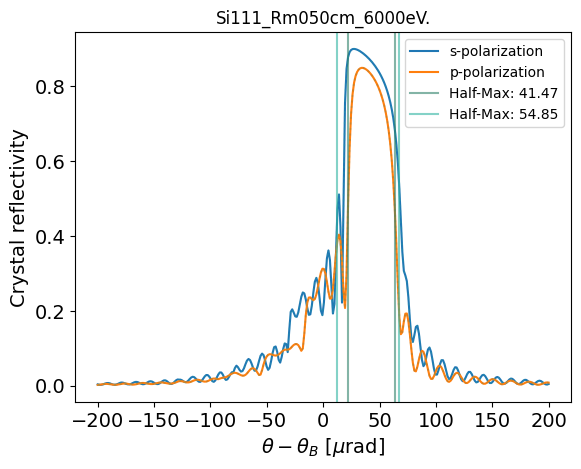

In [159]:
E = 6000
R = -0.5
p = 1.5
cry2det = 1.5

crystal =Bragg_Crystal(E/1000,
                        hkl = [1,1,1],
                        p = p,
                        crystal = 'Si',
                        divergence = 1.2/1000.,
                        R = R,
                        assy_angle=np.deg2rad(0),
                        )
crystal.theta0
crystal.crystal_rotation
crystal.foot_print
crystal.energy_spread_flat
crystal.energy_spread_bent_calc()
crystal.energy_spread_bent_esrf
# crystal.curvature_calc(exp_spread = 400)
crystal.geometric_focus_calc()
crystal.Bragg_size_calc(det2crys_d = cry2det)
# crystal.rotation_spread(2)

crystal.energy_resolution_calc(pixel_size=75)
# crystal.type_writer(sort=False)
crystal.source_size_resolution_calc(source_size=50)
crystal.crystal_resolution_calc(scanfrom=-200, scanto=200, plot=True)

# small GUI for crystal calculation

In [176]:
import ipywidgets as widgets
from IPython.display import display, clear_output

style = {'description_width': '160px'}
width = '300px'

width_02 = '160px'
style_02 = {'description_width': '80px'}


class CrystalCalculator:
    def __init__(self):    
        self.Calulator = Bragg_Crystal
        self.add_rad_deg_converter()        
        self.add_main_menu()
        self.add_calculator_menu()
        self.add_output()
        self.update_calculated_results(change=None)
        self.add_resolution_convolution()
        
    def add_main_menu(self):
        crystal_types = ["Bragg", "Laue", "Multilayer"]
        crystal_types = ["Bragg", "Laue"]
        self.combobox_crystal_type =  widgets.Dropdown(options=crystal_types, value='Bragg', description='Type of calculations', layout=widgets.Layout(width='500px'), style = {'description_width': '200px'})

        self.combobox_crystal_type.observe(self.on_crystal_type_changed, names='value')
        display(self.combobox_crystal_type)
        
    def add_rad_deg_converter(self):
        converter_label = widgets.Label('Units Converter', layout=widgets.Layout(justify_content='center'))

        self.content_text_rad = widgets.FloatText(value=0, placeholder='mili radians', tooltip='', description='Radians', disabled=False, step=.1, layout=widgets.Layout(width=width), style=style)
        self.content_text_deg = widgets.FloatText(value=0, placeholder='degrees', tooltip='', description='Degrees', disabled=False, step=.1, layout=widgets.Layout(width=width), style=style)
        
        self.content_text_rad.observe(self.on_rad2deg, names='value')
        self.content_text_deg.observe(self.on_deg2rad, names='value')

        self.converter_box = widgets.VBox([converter_label,
                                           widgets.HBox([self.content_text_rad,
                                                         self.content_text_deg]),
                                           ], layout=widgets.Layout(border="2px solid black", width='650px', justify_content='center'))
        display(self.converter_box)

    def on_rad2deg(self, change):
        # Avoid infinite loop by only acting on direct user input
        if change['type'] == 'change' and change['name'] == 'value':
            self.content_text_deg.value = np.rad2deg(change['new'])

    def on_deg2rad(self, change):
        # Avoid infinite loop by only acting on direct user input
        if change['type'] == 'change' and change['name'] == 'value':
            self.content_text_rad.value = np.deg2rad(change['new'])
            
    def add_calculator_menu(self):
        self.label_input = widgets.Label('Input parameters')

        self.content_text_h = widgets.IntText(value=1, placeholder='x', description='hkl', disabled=False, step=1, layout=widgets.Layout(width='200px', align_items='stretch'), style=style)
        self.content_text_k = widgets.IntText(value=1, placeholder='y', disabled=False, step=1, layout=widgets.Layout(width='33px'))
        self.content_text_l = widgets.IntText(value=1, placeholder='z',  disabled=False, step=1, layout=widgets.Layout(width='33px'))

        self.content_text_material = widgets.Dropdown(options=['Si', 'Ge'], value='Si', description='Material', disabled=False, layout=widgets.Layout(width=width), style=style)
        self.content_text_p = widgets.BoundedFloatText(value=1.5, placeholder='Source-to-crystal distance', tooltip='Source-to-crystal distance', description='p distance [m]', disabled=False, step=.1, layout=widgets.Layout(width=width), style=style)
        self.content_text_divergence = widgets.BoundedFloatText(value=1.2, min=0, max=1000000, placeholder='Incident beam\'s divergence', description='Divergence [mrad]', disabled=False, step=.1, layout=widgets.Layout(width=width), style=style)
        self.combobox_bent_flat = widgets.Dropdown(options=['Flat', 'Bent'], value='Bent', description = 'Crystal', disabled=False, layout=widgets.Layout(width=width), style=style)

        self.content_text_R = widgets.FloatText(value=-0.5, placeholder='Bending radius', tooltip='positive -> focusing (concave); negative -> diverging (convex)', description='Radius [m]', disabled=True, step=.1, layout=widgets.Layout(width=width), style=style)
        self.content_text_assymetry_angle = widgets.FloatText(value=0, placeholder='Bending radius', tooltip='positive -> upper condition; negative -> lower condition', description='Assy. angle [deg]', disabled=False, step=.1, layout=widgets.Layout(width=width), style=style)
        self.combobox_assymetry_condition = widgets.Dropdown(options=['upper', 'lower'], value='upper', description = 'Assymetry geometry', disabled=False, layout=widgets.Layout(width=width), style=style)
        self.content_text_energy = widgets.BoundedFloatText(value=6000, min=1000, max=100000, placeholder='X-ray energy', tooltip='X-ray energy', description='X-ray energy [eV]', disabled=False, step=1000, layout=widgets.Layout(width=width), style=style)
        self.content_text_detector_pixelsize = widgets.BoundedFloatText(value=75, min=0, max=1e6, step=10, tooltip='The pixel size of position-sensitive detector', description='Detector pixel size [um]', disabled=False, layout=widgets.Layout(width=width), style=style)

        # Layout
        self.hkl_box = widgets.HBox([self.content_text_h, 
                                     self.content_text_k,
                                     self.content_text_l])
        
        self.bent_widget = widgets.HBox([self.combobox_bent_flat,
                                    #self.content_text_R
                                    ])

        self.Bragg_box = widgets.VBox([self.label_input,
                                       widgets.HBox([self.content_text_material,
                                                     self.hkl_box]),
                                       widgets.HBox([self.content_text_energy,
                                                     self.content_text_divergence]),
                                       self.bent_widget,
                                       widgets.HBox([self.content_text_p,
                                                     self.content_text_detector_pixelsize]),
                                       widgets.HBox([self.content_text_assymetry_angle,
                                                     self.combobox_assymetry_condition]),
                                       
                                       ])
        self.add_detector_distance_calculator()
        widgets_to_observe = [self.content_text_energy, 
                              self.content_text_material, 
                              self.content_text_p, 
                              self.content_text_divergence, 
                              self.content_text_R, 
                              self.content_text_assymetry_angle,
                              self.combobox_assymetry_condition,
                              self.content_text_h, 
                              self.content_text_k,
                              self.content_text_l,
                              self.combobox_bent_flat,
                              self.content_text_det2cry,
                              self.content_text_detector_pixelsize
                              ]

        display(self.Bragg_box)
        
        for widget in widgets_to_observe:
            widget.observe(self.update_calculated_results, names='value')

    def add_detector_distance_calculator(self):
        self.content_text_det2cry = widgets.FloatText(value=1.5, tooltip='Detector-to-crystal distance', description='det2cry distance [m]', disabled=False, step=0.1, layout=widgets.Layout(width='230px'), style=style)
        self.content_text_detx = widgets.FloatText(value=None, tooltip='Detector-to-crystal distance\'s projection along x direction (perpendicular to incident X-rays)', description='detx [m]', disabled=True, step=0.1, layout=widgets.Layout(width=width_02), style=style_02)
        self.content_text_detz = widgets.FloatText(value=None, tooltip='Detector-to-crystal distance\'s projection along incident X-ray propagating direction', description='detz [m]', disabled=True, step=0.1, layout=widgets.Layout(width=width_02), style=style_02)
        self.detector_widget = widgets.HBox([self.content_text_det2cry,
                                             self.content_text_detx,
                                             self.content_text_detz])
        
    #     self.content_text_det2cry.observe(self.on_det2cry_to_detxz, names='value')
    #     self.content_text_detx.observe(self.on_detx_to_det2cryz, names='value')
    #     self.content_text_detz.observe(self.on_detz_to_det2cryx, names='value')
    

    # def on_det2cry_to_detxz(self, change):
    #     # Avoid infinite loop by only acting on direct user input
    #     if change['type'] == 'change' and change['name'] == 'value':
    #         self.content_text_detx.value = round(self.content_text_det2cry.value * np.sin(self.CrystalObject.theta0 * 2), 5)
    #         self.content_text_detz.value = round(self.content_text_det2cry.value * np.cos(self.CrystalObject.theta0 * 2), 5)

    # def on_detx_to_det2cryz(self, change):
    #     # Avoid infinite loop by only acting on direct user input
    #     if change['type'] == 'change' and change['name'] == 'value':
    #         self.content_text_det2cry.value = round(self.content_text_detx.value/np.sin(self.CrystalObject.theta0 * 2), 5)
    #         self.content_text_detz.value = round(self.content_text_detx.value/np.tan(self.CrystalObject.theta0 * 2), 5)

    # def on_detz_to_det2cryx(self, change):
    #     # Avoid infinite loop by only acting on direct user input
    #     if change['type'] == 'change' and change['name'] == 'value':
    #         self.content_text_det2cry.value = round(self.content_text_detz.value/np.cos(self.CrystalObject.theta0 * 2), 5)
    #         self.content_text_detx.value = round(self.content_text_detz.value * np.tan(self.CrystalObject.theta0 * 2), 5)
        
    def add_output(self):
        self.label_output = widgets.Label('DXAS calculations')
        self.content_text_Bragg_angle = widgets.BoundedFloatText(value=None, tooltip='Bragg angle', description='Bragg angle [deg]', disabled=True, layout=widgets.Layout(width=width), style=style)
        self.content_text_crystal_rotation_angle = widgets.BoundedFloatText(value=None, tooltip='Crystal rotation angle relative to the incident beam', description='Crystal angle [deg]', disabled=True, layout=widgets.Layout(width=width), style=style)
        self.content_text_delta_theta = widgets.FloatText(value=None, tooltip='the Bragg angle variation along curved crystal', description='Delta theta [deg]', disabled=True, layout=widgets.Layout(width=width), style=style)
        self.content_text_energy_spread = widgets.FloatText(value=None, description='Energy spread [eV]', disabled=True, layout=widgets.Layout(width=width), style=style)
        self.content_text_geometric_focus = widgets.FloatText(value=None, tooltip='Crystal-to-focus distance. Positive -> real focus, Negative -> virtual focus', description='Geometric focus [m]', disabled=True, layout=widgets.Layout(width=width), style=style)
        self.content_text_beam_width = widgets.FloatText(value=None, tooltip='The beam width of the Bragg beam (perpendicular to 2 theta)', description='Bragg beamwidth [mm]', disabled=True, layout=widgets.Layout(width=width), style=style)
        self.content_text_beam_width_x = widgets.FloatText(value=None, tooltip='The beam width of the Bragg beam along x direction (perpendicular to incident X-rays)', description='Beamwidth along x [mm]', disabled=True, layout=widgets.Layout(width=width), style=style)
        self.content_text_footprint = widgets.FloatText(value=None, tooltip='The length of X-ray footprint on the crystal', description='Crystal footprint [mm]', disabled=True, layout=widgets.Layout(width=width), style=style)
        # detector resolution
        self.content_text_detector_resolution = widgets.FloatText(value=None, tooltip='Energy resolution per pixel, NOTE THAT this DOES NOT include broadening effects from source size and crystal intrinsic width!!', description='Detector [eV/pixel]', disabled=True, layout=widgets.Layout(width=width), style=style)
        # self.content_text_detector_resolution_new = widgets.FloatText(value=None, tooltip='Energy resolution per pixel, NOTE THAT this DOES NOT include broadening effects from source size and crystal intrinsic width!!', description='Detector new [eV/pixel]', disabled=True, layout=widgets.Layout(width=width), style=style)
        # source size resolution
        self.content_text_source_size = widgets.BoundedFloatText(value=1.5, min=0, max=1e8, tooltip='Source size', description='Source size [um]', disabled=False, layout=widgets.Layout(width=width), style=style)
        self.content_text_source_width_eV = widgets.FloatText(value=None, description='Source size width [eV]', disabled=True, layout=widgets.Layout(width=width), style=style)
        # self.content_text_source_width_eV_new = widgets.FloatText(value=None, description='Source size width new [eV]', disabled=True, layout=widgets.Layout(width=width), style=style)

        
        self.output_box = widgets.VBox([self.label_output,
                                        self.detector_widget,
                                        widgets.HBox([self.content_text_Bragg_angle,
                                                      self.content_text_crystal_rotation_angle,
                                                      ]),
                                        widgets.HBox([
                                                      self.content_text_energy_spread,
                                                      self.content_text_delta_theta,
                                                      ]),
                                        widgets.HBox([self.content_text_footprint,
                                                     self.content_text_geometric_focus,
                                                     ]),
                                        widgets.HBox([self.content_text_beam_width,
                                                     self.content_text_beam_width_x,
                                                     ]),
                                        
                                        
                                       ])
        display(self.output_box)
    
    def add_resolution_convolution(self):
        self.label_resolution_convolution = widgets.Label('Total energy resolution')

        self.add_crystal_intrinsic_calculator()
        self.content_text_crystal_intrinsic_width_urad = widgets.FloatText(value=None, description='Crystal FWHM [urad]', disabled=True, layout=widgets.Layout(width=width), style=style)
        self.content_text_crystal_intrinsic_width_eV = widgets.FloatText(value=None, description='Crystal FWHM [eV]', disabled=True, layout=widgets.Layout(width=width), style=style)

        self.content_text_total_resolution_eV = widgets.FloatText(value=None, description='Total resolution [eV]', disabled=True, layout=widgets.Layout(width=width), style=style)
        self.content_text_total_resolution = widgets.FloatText(value=None, description='Total resolution [1e-4]', disabled=True, layout=widgets.Layout(width=width), style=style)

        self.output_widget_crystal_intrinsic = widgets.Output()
        self.output_widget_crystal_plot = widgets.Output()

        self.resolution_convolution_box =  widgets.VBox([self.label_resolution_convolution,
                                                        widgets.HBox([self.content_text_detector_resolution,
                                                                      ]),        
                                                        widgets.HBox([self.content_text_source_size, 
                                                                      self.content_text_source_width_eV,
                                                                      ]),                      
                                                        self.crystal_intrinsic_widget,
                                                        widgets.HBox([self.content_text_crystal_intrinsic_width_urad,
                                                                      self.content_text_crystal_intrinsic_width_eV
                                                                      ]),  
                                                        widgets.HBox([self.content_text_total_resolution_eV,
                                                                      self.content_text_total_resolution,
                                                                      ]), 
                                                        self.output_widget_crystal_plot
                                                        ])
        self.button_crystal_calculate.on_click(self.on_button_crystal_calculate)
        display(self.resolution_convolution_box)

    def add_crystal_intrinsic_calculator(self):
        self.content_text_crystal_scan_from = widgets.FloatText(value=-200, step=50, description='Scan region [urad]', disabled=False, layout=widgets.Layout(width=width), style=style)
        self.content_text_crystal_scan_to = widgets.FloatText(value=200, step=50, description='', disabled=False, layout=widgets.Layout(width='150px'), style=style)
        self.button_crystal_calculate = widgets.Button(description='Calculate', disabled=False, layout=widgets.Layout(width='150px'))
        self.crystal_intrinsic_widget = widgets.HBox([
                                                      self.content_text_crystal_scan_from,
                                                      self.content_text_crystal_scan_to,
                                                      self.button_crystal_calculate
                                                      ])

    def on_button_crystal_calculate(self, b):
        scanfrom = self.content_text_crystal_scan_from.value
        scanto = self.content_text_crystal_scan_to.value
        with self.output_widget_crystal_intrinsic:
            clear_output()
            clear_output()
            # plt.close()
            # plt.clf() 
            self.CrystalObject.crystal_resolution_calc(scanfrom=scanfrom, scanto=scanto, plot=True)
            clear_output()
            
        total_energy_resolution = self.CrystalObject.fwhm_convolution() # 2 um FWHM
        
        self.content_text_crystal_intrinsic_width_urad.value =  self.CrystalObject.crystal_delta_theta
        self.content_text_crystal_intrinsic_width_eV.value =  self.CrystalObject.crystal_fwhm
        
        self.content_text_total_resolution_eV.value = total_energy_resolution
        self.content_text_total_resolution.value = total_energy_resolution/self.CrystalObject.energy * 10

    def on_crystal_type_changed(self, change):
        if self.combobox_crystal_type.value == 'Bragg':
            self.Calulator = Bragg_Crystal
        elif self.combobox_crystal_type.value == 'Laue':
            self.Calulator = Laue_Crystal
        else:
            self.Calulator = Crystal
        self.update_calculated_results(None)
        
    def update_calculated_results(self, change):
        if self.combobox_bent_flat.value == 'Flat':
            self.R = 1e10
        else:
            if self.content_text_R.value == 0:
                print('R cannot be 0, use 0.00001 instead')
                self.R = 0.00001
            else:
                self.R = self.content_text_R.value
            
        calc_para = dict(
            energy = self.content_text_energy.value/1000,
            hkl = [self.content_text_h.value, self.content_text_k.value, self.content_text_l.value],
            crystal = self.content_text_material.value,
            p = self.content_text_p.value,
            divergence = self.content_text_divergence.value/1000,
            R = self.R,
            assy_angle = np.deg2rad(self.content_text_assymetry_angle.value),
            condition = self.combobox_assymetry_condition.value
            )
        self.CrystalObject = self.Calulator(**calc_para)
        
        # Bragg angle & rotation angle
        self.content_text_Bragg_angle.value = np.rad2deg(self.CrystalObject.theta0)
        self.content_text_crystal_rotation_angle.value = np.rad2deg(self.CrystalObject.crystal_rotation)
        
        # Energy spread
        if self.combobox_bent_flat.value == 'Flat':
            self.bent_widget.children = tuple([self.combobox_bent_flat])
            energy_spread = self.CrystalObject.energy_spread_flat[0] * 1000
            self.CrystalObject.energy_spread_bent_calc()
            delta_theta = self.content_text_divergence.value()
            
        elif self.combobox_bent_flat.value == 'Bent':
            if self.content_text_R not in self.bent_widget.children:
                self.bent_widget.children = tuple(list(self.bent_widget.children) + [self.content_text_R]) 
            self.CrystalObject.energy_spread_bent_calc()
            self.content_text_R.disabled = False
            energy_spread = self.CrystalObject.energy_spread_bent  * 1000
            delta_theta = self.CrystalObject.delta_theta
            
        self.content_text_energy_spread.value = energy_spread
        self.content_text_delta_theta.value = np.rad2deg(delta_theta)
        # footprint
        self.content_text_footprint.value = self.CrystalObject.foot_print
        # detector distance 
        # self.content_text_detz.unobserve(self.on_detz_to_det2cryx, names='value')
        # self.content_text_detx.unobserve(self.on_detx_to_det2cryz, names='value')
            
        self.content_text_detx.value = np.sin(self.CrystalObject.theta0 * 2) * self.content_text_det2cry.value
        self.content_text_detz.value = np.cos(self.CrystalObject.theta0 * 2) * self.content_text_det2cry.value 
        # self.content_text_detz.observe(self.on_detz_to_det2cryx, names='value')    
        # self.content_text_detx.observe(self.on_detx_to_det2cryz, names='value')
    
        # geometric focus
        self.content_text_geometric_focus.value = self.CrystalObject.geometric_focus_calc()
        # Bragg beam width
        self.content_text_beam_width.value = self.CrystalObject.Bragg_size_calc(det2crys_d = self.content_text_det2cry.value)[0] * 1000
        self.content_text_beam_width_x.value = self.CrystalObject.Bragg_size_calc(det2crys_d = self.content_text_det2cry.value)[1] * 1000
        # pixel resolution 
        self.content_text_detector_resolution.value = self.CrystalObject.energy_resolution_calc(self.content_text_detector_pixelsize.value)
        # source size
        self.CrystalObject.source_size_resolution_calc(source_size=self.content_text_source_size.value)
        self.content_text_source_width_eV.value = self.CrystalObject.source_resolution
# Create an instance of the class
test = CrystalCalculator()

Dropdown(description='Type of calculations', layout=Layout(width='500px'), options=('Bragg', 'Laue'), style=De…

# Si(111)

In [177]:
E = [5000,    5100,   5500,    6000, 6500,   7000,   7500,  8000,  8500,   9000,  9500, 10000, 10500] 
R = [-0.141, -0.148, -0.254,  -0.34, -0.433, -0.595, -0.85, -1.05, -1.29, -1.69, -2.41, -2.79, -4.15]

# from tweaking Si(111)

File written to disk: xcrystal.bra
Running command ''/Users/juanjuanhuang/anaconda3/envs/xraylib/lib/python3.8/site-packages/xoppylib/bin/darwin/diff_pat' < xoppy.inp' in directory: /Users/juanjuanhuang/Library/CloudStorage/Box-Box/01_DispersiveXANESspectrometer/03_Manuscript/2023_DXAS_paper/01_data_analysis/DXAS_simulation/2023_DXAS_calc 

--------------------------------------------------------

  
  
  
 *****************************************************
 *           DIFF_PAT    v1.8  (18 Oct 2016)         *
 *Calculation of a single crystal diffraction profile*
 *                                                   *
 *****************************************************
  
  Name of file with crystal data (from BRAGG):  What kind of crystal you want to use ?: 
         [0] Perfect crystal 
         [1] Mosaic crystal 
         [2] Bent Multilamellar (ML)
         [3] Bent Penning-Polder (PP)
  <?>    What do you want to calculate ?: 
 [0] Diffracted beam in Reflection (Bragg) geo

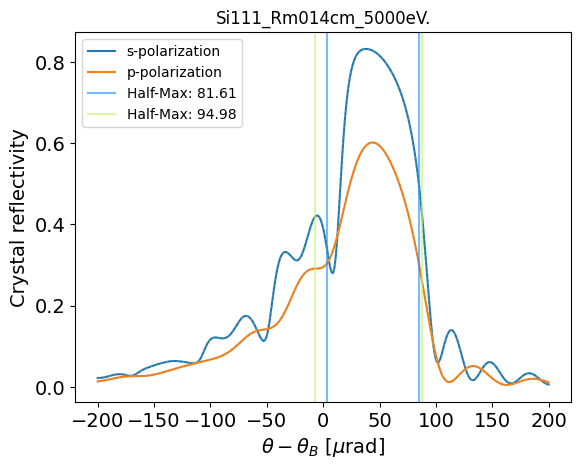

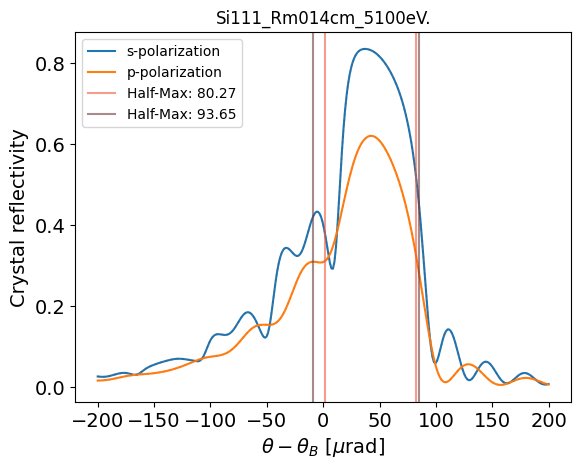

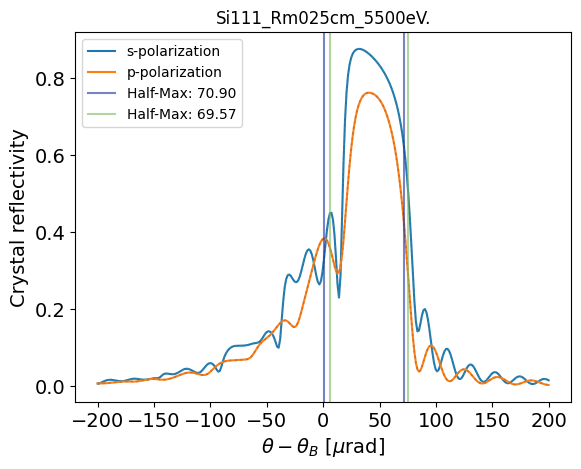

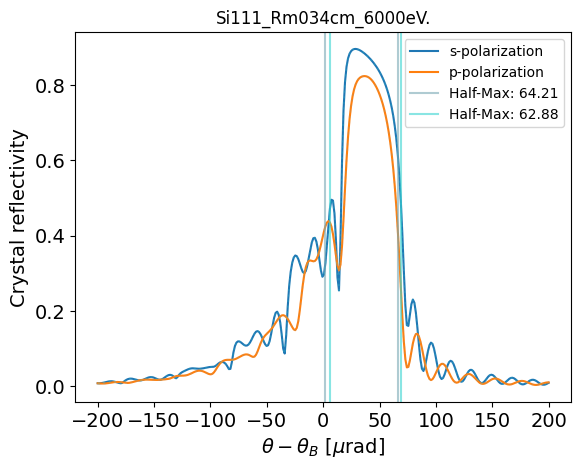

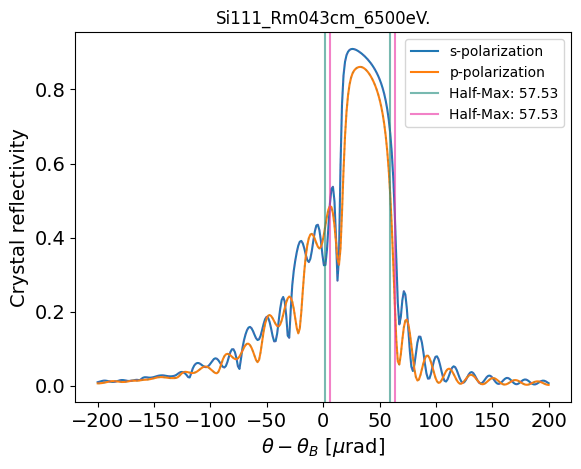

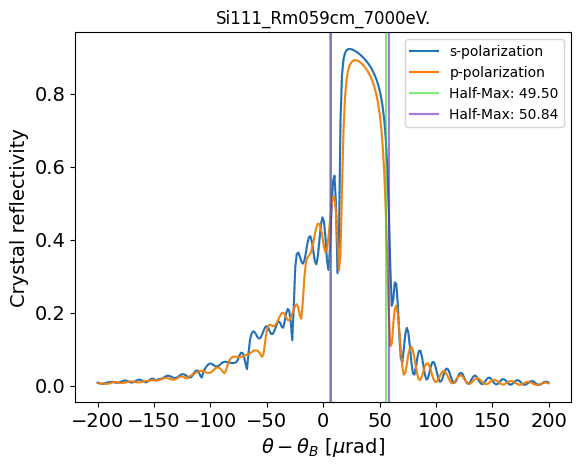

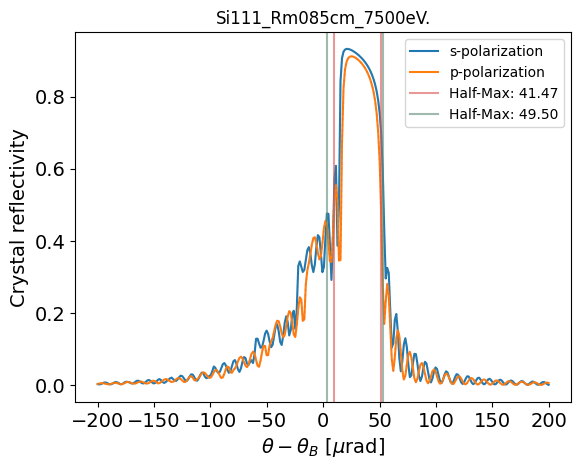

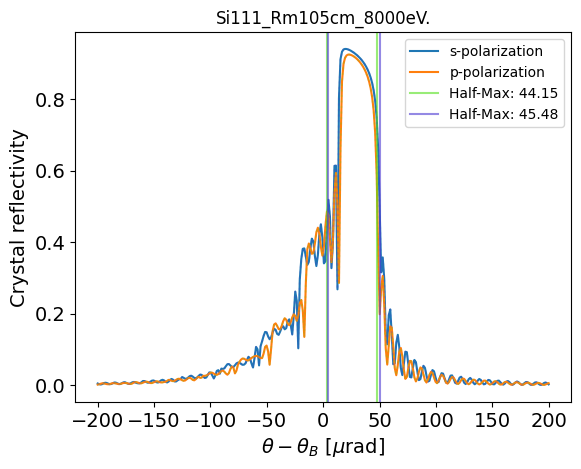

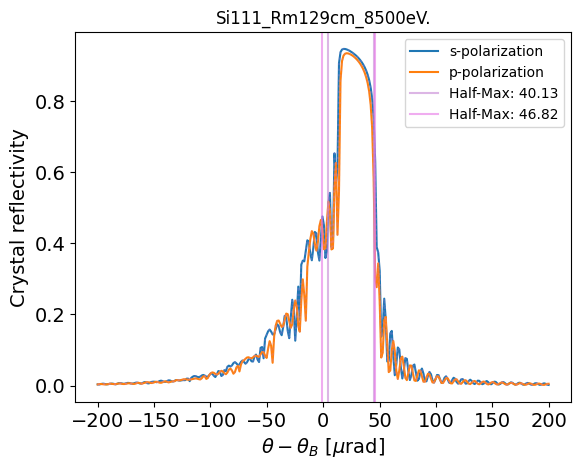

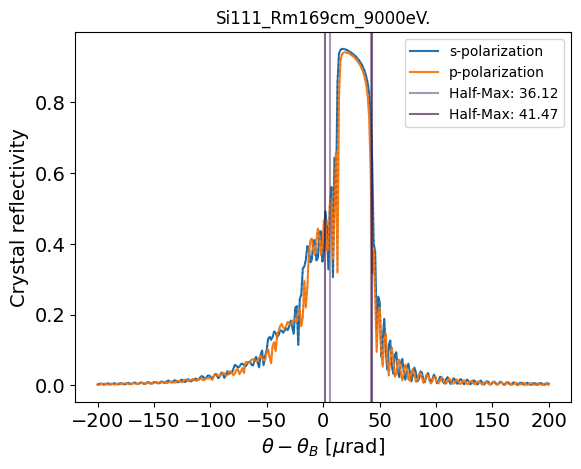

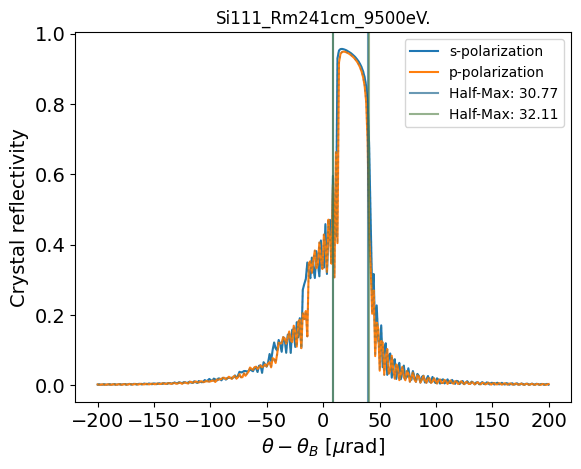

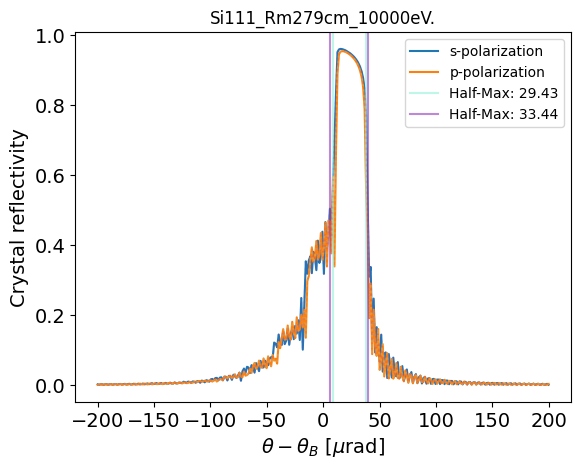

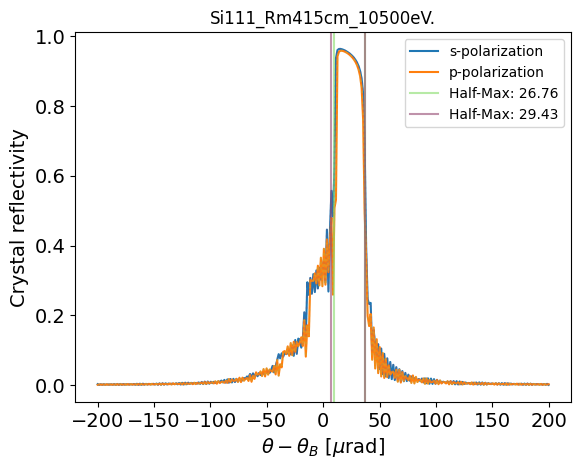

In [179]:
p = 1.5
cry2det = 1.5
divergence = 1.2/1000
energy_range_all = []
source_resolution = []
crystal_resolution = []
total_resolution = []
detector_resolution = []
for i, E_i in enumerate(E):
    crystal =Bragg_Crystal(E_i/1000,
                           hkl = [1,1,1],
                           p = p,
                           crystal = 'Si',
                           divergence = divergence,
                           R = R[i],
                           assy_angle=np.deg2rad(0),
                            )
    crystal.theta0
    crystal.crystal_rotation
    crystal.foot_print
    crystal.energy_spread_flat
    crystal.energy_spread_bent_calc()
    crystal.energy_spread_bent_esrf
    # crystal.curvature_calc(exp_spread = 400)
    crystal.geometric_focus_calc()
    crystal.Bragg_size_calc(det2crys_d = cry2det)
    # crystal.rotation_spread(2)

    crystal.energy_resolution_calc(pixel_size=75)
    # crystal.type_writer(sort=False)
    crystal.source_size_resolution_calc(source_size=1.5)

    crystal.crystal_resolution_calc(scanfrom=-200, scanto=200, plot=True)
    total_resolution.append(crystal.fwhm_convolution())
    energy_range_all.append(crystal.energy_spread_bent * 1000)
    source_resolution.append(crystal.source_resolution)
    crystal_resolution.append(crystal.crystal_fwhm)
    detector_resolution.append(crystal.energy_resolution)


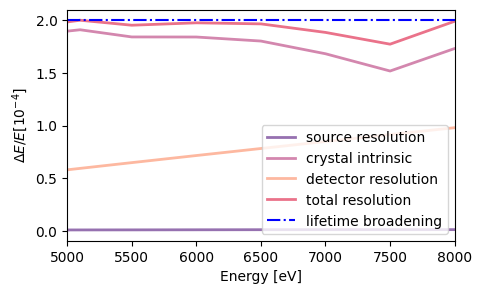

In [180]:
plt.figure(figsize=(5,3))
plot_para = dict(alpha=0.6, lw=2)
colors = plt.cm.magma(np.linspace(0, 1, 5))

plt.plot(E, np.array(source_resolution)/np.array(E) * 1e4, label='source resolution', **plot_para, c=colors[1])
plt.plot(E, np.array(crystal_resolution)/np.array(E) * 1e4, label = 'crystal intrinsic', **plot_para, c=colors[2])
plt.plot(E, np.array(detector_resolution)/np.array(E) * 1e4, label = 'detector resolution', **plot_para, c=colors[3])
plt.plot(E, np.array(total_resolution)/np.array(E) * 1e4, label='total resolution', **plot_para, c='crimson')
plt.axhline(y=2, color='b', linestyle='-.', label='lifetime broadening')
plt.legend(loc = 'lower right');
plt.ylabel('$ \\Delta E / E [10^{-4}]$');
plt.xlabel('Energy [eV]');
plt.xlim(5000, 8000);

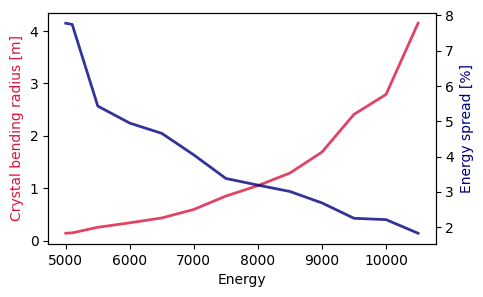

In [182]:
# E = [8500, 9000, 9500, 10000] 
# R = [-0.55, -0.75, 0.9, -1.1]
#  = []
# source_resolution = []
# crystal_resolution = []
# total_resolution = []

c1 = 'crimson'
c2 = 'navy'
fig, ax1 = plt.subplots(figsize=(5,3))

ax2 = ax1.twinx()
ax1.plot(E, -np.array(R), c1, alpha=0.8, lw=2)
ax2.plot(E, np.array(energy_range_all)/E * 100, c2, alpha=0.8, lw=2)
# ax2.plot(E, np.array(energy_range_all), c2, alpha=0.8, lw=2)

ax1.set_xlabel('Energy')
ax1.set_ylabel('Crystal bending radius [m]', color=c1)
ax2.set_ylabel('Energy spread [%]', color=c2);

In [74]:
75*1e-6/(test.content_text_det2cry.value - test.CrystalObject.f_g) * test.CrystalObject.energy * 1000/np.tan(test.CrystalObject.theta0)

1.1982081599206986

In [16]:
test.CrystalObject.theta0

0.33578303488112554

In [15]:
test.CrystalObject.beam_size * 1e3* test.CrystalObject.f_g / (test.CrystalObject.f_g - test.CrystalObject.det2crys_d) 

70.72491730347714

In [ ]:
from xoppylib.crystals.tools import bragg_calc2, run_diff_pat
import xraylib
from dabax.dabax_xraylib import DabaxXraylib

def get_Bragg_resolution(hkl=[1,1,1], E=8333, scanfrom=-200, scanto=100, R_m=150, scanpnts=300):
    bragg_dictionary = bragg_calc2(
    descriptor = "Si",
    hh         = hkl[0], 
    kk         = hkl[1], 
    ll         = hkl[2], 
    temper     = 1.0, 
    emin       = E-100,
    emax       = E+100,
    estep      = 0.4,
    ANISO_SEL  = 0,
    fileout    = "xcrystal.bra",
    do_not_prototype = 0,  # 0=use site groups (recommended), 1=use all individual sites
    verbose = False,
    material_constants_library = xraylib,
    );

    # run external (fortran) diff_pat (note that some parameters may not be used)
    run_diff_pat( 
        bragg_dictionary,
        preprocessor_file  = "xcrystal.bra",
        descriptor         = "Si",
        MOSAIC             = 2, 
        GEOMETRY           = 0, 
        SCAN               = 2, 
        UNIT               = 1, 
        SCANFROM           = scanfrom, 
        SCANTO             = scanto, 
        SCANPOINTS         = scanpnts, 
        ENERGY             = E, 
        ASYMMETRY_ANGLE    = 0.0, 
        THICKNESS          = 0.02, # cm
        MOSAIC_FWHM        = 0.1, 
        RSAG               = 1000000000.0, 
        RMER               = R_m, 
        ANISOTROPY         = 0, 
        POISSON            = 0.22, 
        CUT                = "2 -1 -1 ; 1 1 1 ; 0 0 0",
        FILECOMPLIANCE     = "mycompliance.dat", 
        )
    data_i = np.loadtxt("diff_pat.dat", skiprows=5)
    # noinspection PyBroadException
    try:
        os.mkdir("Crystal_reflectivity")
    except:
        pass

    save_name = "Crystal_reflectivity/Si%d%d%d_Rm%03dcm_%deV.dat"%(hkl[0], hkl[1], hkl[2], R_m, E)
    np.savetxt(save_name, data_i)
    return save_name


class EnergyResolution(Bragg_Crystal):
    def __init__(self, **para):
        super().__init__(**para)
    
    # def energy_resolution_calc(self, pixel_size=55):
    #     self.pixel_size = pixel_size
    #     self.detector_resolution = self.energy_spread_bent * 1000 / (self.Bragg_size/(pixel_size/1e6))
    #     self.printlst['Bragg13_energy_resolution'] = 'Energy resolution (pixel size = %.1f): %.2f eV/pixel'%(pixel_size, self.detector_resolution)
    #     return self.detector_resolution
    
    def crystal_resolution_calc(self, scanfrom=-200, scanto=100, scanpnts=300, plot=True):
        file_name = get_Bragg_resolution(hkl=self.hkl, 
                                         E=self.energy*1000, 
                                         scanfrom=scanfrom, 
                                         scanto=scanto, 
                                         R_m=np.abs(self.R*100), 
                                         scanpnts=scanpnts)
            
        data_lst = glob.glob(file_name)
        R, FWHM_reflect_p, FWHM_reflect_s = reflectivity_data_get(data_lst, plot=plot)
        self.crystal_delta_theta = FWHM_reflect_p[0]
        
    def fwhm_convolution(self, source_size):
        # self.source_resolution = self.angle_to_energy_spread_calc(source_size / self.p/1e6) * 1000
        # new version after discussion with Xianbo
        self.source_resolution = self.f_g /(self.f_g - self.det2crys_d)  * source_size / self.p
        
        self.crystal_fwhm = self.angle_to_energy_spread_calc(self.crystal_delta_theta/1e6) * 1000
        total_resolution = np.sqrt(self.source_resolution ** 2 + self.detector_resolution ** 2 + self.crystal_fwhm ** 2)
        
        self.printlst['zz_z00_total_energy_resolution'] = f'{"-"*50}\nTotal resolution: {total_resolution:.3f} eV'
        self.printlst['zz_z01_crystal_resolution'] = f'Crystal resolution: {self.crystal_fwhm:.3f} eV'
        self.printlst['zz_z02_detector_resolution'] = 'Detector resolution (pixel size = %.1f): %.2f eV/pixel'%(self.pixel_size, self.detector_resolution)
        self.printlst['zz_z03_source_resolution'] = f'Source resolution: {self.source_resolution:.3f} eV'

        return total_resolution
    
        
test = get_Bragg_resolution(hkl=[1,1,1], E=8333, scanfrom=-200, scanto=100, R_m=150, scanpnts=300)


In [ ]:
crystal =Bragg_Crystal(5,
                        hkl = [-1,-1,-1],
                        p = 1,
                        crystal = 'Si',
                        divergence = 5.,
                        R = 1,
                        assy_angle=np.deg2rad(-5),
                        condition = 'upper'
                        )
crystal.theta0
crystal.crystal_rotation
crystal.foot_print
crystal.energy_spread_flat
crystal.energy_spread_bent_calc()
crystal.energy_spread_bent_esrf
# crystal.curvature_calc(exp_spread = 400)
crystal.geometric_focus_calc()
crystal.Bragg_size_calc(det2crys_d = 1)
crystal.det2cen_calc(det2crys_d = 1)
# crystal.rotation_spread(2)
crystal.energy_resolution_calc(75)
crystal.type_writer(sort=False)

In [54]:
crystal.source_resolution_old

0.8710932262370056

In [ ]:
crystal =Laue_Crystal(24.5,
                        hkl = [1,1,1],
                        surface_hkl=[1,0,0],
                        p = 3.8,
                        crystal = 'Si',
                        divergence = 4/1000.,
                        T = 0.0002, # m
                        R = -13,)
crystal.assy_angle;
crystal.crystal_rotation;
crystal.energy_spread_bent_calc()
crystal.curvature_calc(exp_spread = 400)
crystal.single_ray_focus_calc()
crystal.geometric_focus_calc()
crystal.Borrmann_calc()
crystal.Borrmann_bent_calc()
crystal.magic_condition_calc()
crystal.Bragg_size_calc(det2crys_d = 0.4)
crystal.rotation_spread(2)
crystal.energy_resolution_calc(0.2)
crystal.type_writer()

## Load EnergyResolution

In [ ]:
det2crys = 2
resolution = EnergyResolution(energy=9,
                              hkl = [1,1,1],
                              p = 0.5,
                              divergence = 1.2/1000.,
                              R = -0.5,
                              )

resolution.energy_spread_bent_calc()
resolution.det2cen_calc(det2crys_d=det2crys)
resolution.geometric_focus_calc()
resolution.Bragg_size_calc(det2crys_d=det2crys)
resolution.energy_resolution_calc(55)
resolution.crystal_resolution_calc(scanfrom=-150, scanto=150, plot=True)
total = resolution.fwhm_convolution(source_size=2/1e6) # 2 um FWHM

In [ ]:
test = get_Bragg_resolution(hkl=[1,1,1], 
                            E=8333,
                            scanfrom=-200, 
                            scanto=100, 
                            R_m=60, scanpnts=300)


In [ ]:
resolution.type_writer()

In [ ]:
dety = 1200
dety = 2360
dety = 1760
dety = 1610

crystal =Bragg_Crystal(6.539,
                       hkl = [1,1,1],
                      #  p = 0.42743,
                       p = 2.1,
                       crystal = 'Si',
                       divergence = 1/1000.,
                       R = -2,
                       assy_angle=np.deg2rad(0),
                       condition = 'upper'
                      )
crystal.foot_print;
crystal.det2cen_calc(dety=dety)
crystal.energy_spread_flat
crystal.energy_spread_bent_calc()
crystal.geometric_focus_calc()
crystal.rotation_spread(np.deg2rad(1))
crystal.Bragg_size_calc(dety=dety/1000)
crystal.energy_resolution_calc(55)
crystal.type_writer(sort=False)

In [ ]:
%matplotlib widget
window1 = ButtonOutputManager()
window1.init_display()

In [ ]:
dety = 1250
dety = 1800
dety = 2170
crystal =Bragg_Crystal(8.979,
                       hkl = [1,1,1],
                       p = 0.72,
                       divergence = 1.2/1000.,
                       R = -2,
                       assy_angle=np.deg2rad(0),
                       condition = 'upper'
                      )
crystal.foot_print;
crystal.det2cen_calc(dety=dety)
crystal.energy_spread_flat
crystal.energy_spread_bent_calc()
crystal.energy_spread_bent_esrf
crystal.geometric_focus_calc()
crystal.rotation_spread(1.1/2)
crystal.Bragg_size_calc(dety=dety/1000)
crystal.energy_resolution_calc(55)
crystal.type_writer(sort=False)
# crystal.angle_to_energy_spread_calc(10/1e6)

In [ ]:
E = np.arange(5, 15, 0.1)
p = 1.5
R = -1

R_response_111 = {"foot_print"           :[],
                  "det2cen"              :[],
                  "energy_spread_bent"   :[],
                  "geometric_focus"      :[],
                  "Bragg_size"           :[],
                  "energy_resolution"    :[],
                 }
for E_i in E:
    dety = 750
    crystal =Bragg_Crystal(E_i,
                          hkl = [1,1,1],
                          #  p = 0.42743,
                          p = p,
                          crystal = 'Si',
                          divergence = 1.2/1000.,
                          R = R,
                          assy_angle=np.deg2rad(0),
                          condition = 'upper'
                          )
    R_response_111["foot_print"].append(crystal.foot_print)
    R_response_111["det2cen"].append(crystal.det2cen_calc(dety=dety))
    R_response_111["energy_spread_bent"].append(crystal.energy_spread_bent_calc()*1000)
    R_response_111["geometric_focus"].append(crystal.geometric_focus_calc())
    R_response_111["Bragg_size"].append(crystal.Bragg_size_calc(dety=dety/1000)[0]*1000)
    R_response_111["energy_resolution"].append(crystal.energy_resolution_calc(55))


# Spectrometor energy resolution

## Load ML24 & ML48 & Lifetime broadening data

In [ ]:
E_ML24 = np.loadtxt("E_all_ML24.txt")
fwhm_ML24 = np.loadtxt("FWHM_all_ML24.txt")
E_ML48 = np.loadtxt("E_all_ML48.txt")
fwhm_ML48 = np.loadtxt("FWHM_all_ML48.txt")

E_lifetime = np.loadtxt("K_edge_energies.dat")
lifetime = np.loadtxt("K_lifetime_resolution.dat")

# Reduce data points

In [ ]:
keys='energy_spread_bent'
plt.figure(figsize=(5,3))
# plt.plot(E, np.asarray(R_response[keys]), lw = 3, alpha = 0.6, color = "navy", label = 'Si(220)')
# plt.plot(E, np.asarray(R_response_111[keys]), lw = 3, alpha = 0.8, color = "crimson", label = 'Si(111)')
plt.plot(E_ML24[100:]/1000, fwhm_ML24[100:], lw=2, ls="-", alpha = 0.8, color = "navy", label = 'ML24')
plt.plot(E_ML24[:100]/1000, fwhm_ML24[:100], lw=2, ls=":", alpha = 0.8, color = "navy")
plt.plot(E_ML48[:-507]/1000, fwhm_ML48[:-507], lw = 2, ls="-", alpha = 0.8,color = "crimson", label = 'ML48')
plt.plot(E_ML48[-507:]/1000, fwhm_ML48[-507:], lw = 2, ls=":", alpha = 0.8,color = "crimson")

plt.xticks(np.arange(5, 15.5, 1))
# plt.ylim(0, 500)
plt.xlabel('Energy [keV]', fontsize = 11)
plt.ylabel('Energy spread $\Delta$E', fontsize = 11)
plt.grid(alpha = 0.6)
plt.ylim(0, 450)
plt.xlim(5,15)
plt.legend()
plt.tight_layout()
# plt.savefig("crystal_spread.jpg", dpi = 300)
plt.savefig("ML_bandwidth.jpg", dpi = 300)

## test

In [ ]:
test = 'Crystal_reflectivity/Si111_Rm100cm_8380eV.dat'
data_lst = glob.glob(test)
R, FWHM_reflect_p, FWHM_reflect_s = reflectivity_data_get(data_lst, plot=True)

## Si(1,1,1), R=0.5m & R=1m

In [ ]:
response_all = {}

skip_step = 10
E = E_ML48[::skip_step].copy()/1000
BW_all = fwhm_ML48[::skip_step].copy()


R_all = [-0.5, -1] 
hkl = [1,1,1]

for R in R_all:
    title=f"R={np.abs(R)}m_hkl({hkl[0]},{hkl[1]},{hkl[2]})"
    para = {"R": R,
            "divergence": 1.2/1000, 
            "printit":0}


    response = {"p":[],
                "d":[],
                "det2cen":[],
                "resolution":[],
                "crystal_resolution":[],
                "detector_resolution":[],
                "source_resolution":[],
                }

    for i, E_i in enumerate(E):
        crystal = Crystal(E_i, hkl = hkl)
        para["theta0"] = crystal.theta0
        crystalInvert = BraggCrystalInvert(E=E_i, **para)

        p = crystalInvert.p_calc(BW_all[i]/1000)
        response["p"].append(p)
        d = crystalInvert.det_calc(Braggsize=28)
        response["d"].append(d)
        
        resolution = EnergyResolution(energy=E_i,
                                  hkl=hkl,
                                  p=p,
                                  divergence=para["divergence"],
                                  R=para["R"],
                                  )
        
        resolution.energy_spread_bent_calc()
        resolution.geometric_focus_calc()
        resolution.Bragg_size_calc(det2crys_d=d)
        resolution.energy_resolution_calc(pixel_size=55)
        resolution.crystal_resolution_calc(scanfrom=-300, scanto=300, plot=False)
        total_resolution = resolution.fwhm_convolution(source_size=2/1e6)
        
        response["det2cen"].append(resolution.det2cen_calc(det2crys_d=d))
        response["resolution"].append(total_resolution)
        response["crystal_resolution"].append(resolution.crystal_fwhm)
        response["detector_resolution"].append(resolution.detector_resolution)
        response["source_resolution"].append(resolution.source_resolution)


    response_all[title] = response

## Si(2,2,0), R=0.5m 

In [ ]:
R = -0.5
hkl = [2,2,0]

title=f"R={np.abs(R)}m_hkl({hkl[0]},{hkl[1]},{hkl[2]})"
para = {"R": R,
        "divergence": 1.2/1000, 
        "printit":0}


response = {"p":[],
            "d":[],
            "det2cen":[],
            "resolution":[],
            "crystal_resolution":[],
            "detector_resolution":[],
            "source_resolution":[],
            }

for i, E_i in enumerate(E):
    crystal = Crystal(E_i, hkl = hkl)
    para["theta0"] = crystal.theta0
    crystalInvert = BraggCrystalInvert(E=E_i, **para)

    p = crystalInvert.p_calc(BW_all[i]/1000)
    response["p"].append(p)
    d = crystalInvert.det_calc(Braggsize=28)
    response["d"].append(d)

    resolution = EnergyResolution(energy=E_i,
                              hkl=hkl,
                              p=p,
                              divergence=para["divergence"],
                              R=para["R"],
                              )

    resolution.energy_spread_bent_calc()
    resolution.geometric_focus_calc()
    resolution.Bragg_size_calc(det2crys_d=d)
    resolution.energy_resolution_calc(pixel_size=55)
    resolution.crystal_resolution_calc(scanfrom=-300, scanto=300, plot=False)
    total_resolution = resolution.fwhm_convolution(source_size=2/1e6)

    response["det2cen"].append(resolution.det2cen_calc(det2crys_d=d))
    response["resolution"].append(total_resolution)
    response["crystal_resolution"].append(resolution.crystal_fwhm)
    response["detector_resolution"].append(resolution.detector_resolution)
    response["source_resolution"].append(resolution.source_resolution)


response_all[title] = response

## Si(2,2,0), R=1m, reduced
---
p is too big

In [ ]:
hkl = [2,2,0]
R = -1

title=f"R={np.abs(R)}m_hkl({hkl[0]},{hkl[1]},{hkl[2]})"
para = {"R": R,
        "divergence": 1.2/1000, 
        "printit":0}


response = {"p":[],
            "d":[],
            "det2cen":[],
            "resolution":[],
            "crystal_resolution":[],
            "detector_resolution":[],
            "source_resolution":[],
            "energy_range":[]
            }

for i, E_i in enumerate(E):
    crystal = Crystal(E_i, hkl = hkl)
    para["theta0"] = crystal.theta0
    crystalInvert = BraggCrystalInvert(E=E_i, **para)

    p = crystalInvert.p_calc(BW_all[i]/1000) - 2 + E_i/10 # reduce p here
    response["p"].append(p)
    d = crystalInvert.det_calc(Braggsize=28)
    response["d"].append(d)

    resolution = EnergyResolution(energy=E_i,
                              hkl=hkl,
                              p=p,
                              divergence=para["divergence"],
                              R=para["R"],
                              )

    resolution.energy_spread_bent_calc()
    resolution.geometric_focus_calc()
    resolution.Bragg_size_calc(det2crys_d=d)
    resolution.energy_resolution_calc(pixel_size=55)
    resolution.crystal_resolution_calc(scanfrom=-300, scanto=300, plot=False)
    total_resolution = resolution.fwhm_convolution(source_size=2/1e6)

    response["det2cen"].append(resolution.det2cen_calc(det2crys_d=d))
    response["resolution"].append(total_resolution)
    response["crystal_resolution"].append(resolution.crystal_fwhm)
    response["detector_resolution"].append(resolution.detector_resolution)
    response["source_resolution"].append(resolution.source_resolution)
    response["energy_range"].append(resolution.energy_spread_bent_calc())

    response_all[title] = response

In [ ]:
key_i = 'R=1m_hkl(2,2,0)'
plot_para = {"lw":2, "alpha":0.9}

# p,d distances
plt.figure(figsize=(10,3))
plt.plot(E, response_all[key_i]["p"], **plot_para, color = 'crimson',  label = "focus-to-crystal")
plt.plot(E, response_all[key_i]["d"], ls = '-', **plot_para, color = 'navy', label = "crystal-to-detector")
plt.plot(E, response_all[key_i]["det2cen"], ls = '-', **plot_para, color = 'k', label = "detector-to-center")
plt.hlines(y=3, xmin=0, xmax=10, ls=':', color='k',alpha=0.5); 
plt.xticks(np.arange(5.5, 16, 0.2), fontsize = 12); plt.yticks(fontsize = 12)
plt.xlim(5.5, 9.5); plt.ylim(0,6);plt.yticks(np.arange(0,6.1,0.5));
plt.xlabel("Energy [keV]", fontsize = 12);plt.ylabel("Distance [m]", fontsize = 12);
plt.grid(ls='--',alpha=0.5);plt.legend();plt.title(key_i);plt.tight_layout();
# lifetime

plt.figure(figsize=(10,3))
plt.plot(E_lifetime, lifetime, color='lightgreen', lw = 3, label="K hole lifetime")
plt.plot(E, response_all[key_i]["resolution"]/E*10, **plot_para, color = 'k',  label = "Total resolution")
plt.plot(E, response_all[key_i]["source_resolution"]/E*10, alpha=0.7, ls='-.', color = 'crimson',  label = "KB focus resolution")
plt.plot(E, response_all[key_i]["crystal_resolution"]/E*10, alpha=0.7, ls='-.', color = 'navy',  label = "crystal resolution")
plt.plot(E, response_all[key_i]["detector_resolution"]/E*10,  alpha=0.7, ls='-.', color = 'purple',  label = "detector resolution")
plt.xlabel("Energy [keV]", fontsize = 12);plt.ylabel("Energy resolution [$10^{-4}$]", fontsize = 12)
plt.xticks(np.arange(5.5, 16, 0.2), fontsize = 12);plt.yticks(fontsize = 12)
plt.xlim(5.5, 9.5); plt.ylim(-0.1,3);plt.yticks(np.arange(-0.1,3, 0.5));
plt.grid(ls='--',alpha=0.5);plt.legend();plt.tight_layout();


plt.figure(figsize=(10,3))
plt.plot(E, np.asarray(response_all[key_i]["energy_range"])*1000, **plot_para, color = 'k',  label = "Crystal")
plt.plot(E_ML48/1000, fwhm_ML48, lw = 2, ls="-", alpha = 0.8,color = "crimson",  label = "ML 48")
plt.xlabel("Energy [keV]", fontsize = 12);plt.ylabel("Energy range [eV]", fontsize = 12);
plt.xticks(np.arange(5.5, 16, 0.2), fontsize = 12);plt.yticks(fontsize = 12)
plt.xlim(5.5, 9.5); plt.ylim(100,320);#plt.yticks(np.arange(-0.1,3, 0.5));
plt.grid(ls='--',alpha=0.5);plt.legend();plt.tight_layout();

# Plot

## individual plots

In [ ]:
plot_para = {"lw":2, "alpha":0.9}

for key_i in response_all.keys():
    # p,d distances
    plt.figure(figsize=(10,3))
    plt.plot(E, response_all[key_i]["p"], **plot_para, color = 'crimson',  label = "focus-to-crystal")
    plt.plot(E, response_all[key_i]["d"], ls = '-', **plot_para, color = 'navy', label = "crystal-to-detector")
    plt.plot(E, response_all[key_i]["det2cen"], ls = '-', **plot_para, color = 'k', label = "detector-to-center")

    plt.xticks(np.arange(5.5, 16, 0.2), fontsize = 12); plt.yticks(fontsize = 12)
    plt.xlim(5.5, 9.5); plt.ylim(0,4.8);plt.yticks(np.arange(0,5,0.5));
    plt.xlabel("Energy [keV]", fontsize = 14);plt.ylabel("Distance [m]", fontsize = 14);
    plt.grid(ls='--',alpha=0.5);plt.legend();plt.title(key_i);plt.tight_layout();
    # lifetime
    # plt.savefig(f"distances_{key_i}.jpg", dpi=300)
    
    plt.figure(figsize=(10,3))
    plt.plot(E_lifetime, lifetime, color='lightgreen', lw = 3, label="K hole lifetime")
    plt.plot(E, response_all[key_i]["resolution"]/E*10, **plot_para, color = 'k',  label = "Total resolution")
    plt.plot(E, response_all[key_i]["source_resolution"]/E*10, alpha=0.7, ls='-.', color = 'crimson',  label = "KB focus resolution")
    plt.plot(E, response_all[key_i]["crystal_resolution"]/E*10, alpha=0.7, ls='-.', color = 'navy',  label = "crystal resolution")
    plt.plot(E, response_all[key_i]["detector_resolution"]/E*10,  alpha=0.7, ls='-.', color = 'purple',  label = "detector resolution")
    plt.xlabel("Energy [keV]", fontsize = 14);plt.ylabel("Energy resolution [$10^{-4}$]", fontsize = 14)
    plt.xticks(np.arange(5.5, 16, 0.2), fontsize = 12);plt.yticks(fontsize = 12)
    plt.xlim(5.5, 9.5); plt.ylim(-0.1,3);plt.yticks(np.arange(-0.1,3, 0.5));
    plt.grid(ls='--',alpha=0.5);plt.legend();plt.title(key_i);plt.tight_layout();
    # plt.savefig(f"resolution_{key_i}.jpg", dpi=300)

In [ ]:
response_all.keys()

## Manuscript plot

In [ ]:
step = skip_step
Si111_slice_op5 = np.s_[:250//step]
Si111_slice = np.s_[250//step:480//step]
Si220_slice_0p5 = np.s_[480//step:580//step]
Si220_slice = np.s_[580//step:]

# plt.figure(figsize=(10,6))
plot_para = {"lw":2.5, "alpha":0.6}
key = 'R=0.5m_hkl(1,1,1)'
plt.plot(E[Si111_slice_op5], response_all[key]["p"][Si111_slice_op5], **plot_para, color = 'crimson')
plt.plot(E[Si111_slice_op5], response_all[key]["d"][Si111_slice_op5], ls = '--', **plot_para, color = 'crimson')


key = 'R=1m_hkl(1,1,1)'
plt.plot(E[Si111_slice], response_all[key]["p"][Si111_slice], **plot_para, color = 'chocolate')
plt.plot(E[Si111_slice], response_all[key]["d"][Si111_slice], ls = '--', **plot_para, color = 'chocolate')


key = 'R=0.5m_hkl(2,2,0)'
plt.plot(E[Si220_slice_0p5], response_all[key]["p"][Si220_slice_0p5], **plot_para, color = 'darkolivegreen')
plt.plot(E[Si220_slice_0p5], response_all[key]["d"][Si220_slice_0p5], ls = '--', **plot_para, color = 'darkolivegreen')

key = 'R=1m_hkl(2,2,0)'
plt.plot(E[Si220_slice], response_all[key]["p"][Si220_slice], **plot_para, color = 'navy')
plt.plot(E[Si220_slice], response_all[key]["d"][Si220_slice], ls = '--', **plot_para, color = 'navy')

plt.plot(100,100,ls='-', color='gray',alpha=0.5,lw=2.5,  label='KB focus-to-crystal')
plt.plot(100,100,ls='--', color='gray', alpha=0.5,lw=2.5, label='crystal-to-detector')

plt.fill_between(np.linspace(0,6.47,20), y1=0, y2=10, color='brown', alpha=0.05)
plt.fill_between(np.linspace(6.49,7.67,20), y1=0, y2=10, color='orange', alpha=0.05)
plt.fill_between(np.linspace(7.69,8.2,10), y1=0, y2=10, color='green', alpha=0.05)
plt.fill_between(np.linspace(8.22,9.5,10), y1=0, y2=10, color='blue', alpha=0.05)

# plt.plot(E_ML24[ML24_slice]/1000, response_Si111_ML24["p"][ML24_slice], **plot_para, color = 'crimson', ls='--')
# plt.plot(E_ML24[ML24_slice]/1000, response_Si111_ML24["d"][ML24_slice], **plot_para, color = 'navy', ls='--')
# plt.fill_between(E_ML24[ML24_slice]/1000, y1=0, y2=10, color='green', alpha=0.05)

plt.xticks(np.arange(5.5, 16, 0.5), fontsize = 12); plt.yticks(fontsize = 12)
plt.xlabel("Energy [keV]", fontsize = 14); plt.ylabel("Distance [m]", fontsize = 14)
plt.xlim(5.5, 9.5); plt.ylim(0,3);plt.legend(fontsize = 12);plt.tight_layout()

plt.savefig(f"{date_today()}_comparison_distance.jpg", dpi = 300)

In [ ]:
step = skip_step
Si111_slice_op5 = np.s_[:250//step]
Si111_slice = np.s_[250//step:480//step]
Si220_slice_0p5 = np.s_[480//step:580//step]
Si220_slice = np.s_[580//step:]
plot_para = {"lw":2.5, "alpha":0.6}

plt.figure()
plt.plot(E_lifetime, lifetime, color='lightgreen', lw = 3, label="K hole lifetime")

key = 'R=0.5m_hkl(1,1,1)'
plt.plot(E[Si111_slice_op5], np.asarray(response_all[key]["resolution"][Si111_slice_op5]/E[Si111_slice_op5]*10), 
         color = 'crimson', alpha=0.6, label = "Si(111) 0.5 m", ls='-', lw =3)


key = 'R=1m_hkl(1,1,1)'
plt.plot(E[Si111_slice], np.asarray(response_all[key]["resolution"][Si111_slice]/E[Si111_slice]*10), 
         color = 'chocolate', alpha=0.6, label = "Si(111) 1 m", ls='-', lw =3)


key = 'R=0.5m_hkl(2,2,0)'
plt.plot(E[Si220_slice_0p5], np.asarray(response_all[key]["resolution"][Si220_slice_0p5]/E[Si220_slice_0p5]*10), 
         color = 'darkolivegreen', alpha=0.6, label = "Si(220) 0.5 m", ls='-', lw =3)

key = 'R=1m_hkl(2,2,0)'
plt.plot(E[Si220_slice], np.asarray(response_all[key]["resolution"][Si220_slice]/E[Si220_slice]*10), 
         color = 'navy', alpha=0.6, label = "Si(220) 0.5 m", ls='-', lw =3)

plt.fill_between(np.linspace(0,6.47,20), y1=0, y2=10, color='brown', alpha=0.05)
plt.fill_between(np.linspace(6.49,7.67,20), y1=0, y2=10, color='orange', alpha=0.05)
plt.fill_between(np.linspace(7.69,8.2,10), y1=0, y2=10, color='green', alpha=0.05)
plt.fill_between(np.linspace(8.22,9.5,10), y1=0, y2=10, color='blue', alpha=0.05)

plt.ylim(0,4)
plt.xlabel("Energy [keV]", fontsize = 14)
plt.xticks(np.arange(5.5, 16, 0.5), fontsize = 12);plt.yticks(fontsize = 12)
plt.ylabel("Energy resolution [$10^{-4}$]", fontsize = 14)
plt.xlim(5.5, 9.5);plt.legend(fontsize = 12, ncol=1);plt.tight_layout()

plt.savefig(f"{date_today()}_comparison.pdf", dpi = 300)

### ML 48, Si(111)

In [ ]:
para = {"R": -1,
        "divergence": 1.2/1000, 
        "printit":0}

hkl = [1,1,1]

response = {"p":[],
            "d":[],
            "resolution":[],
            }

E = E_ML48/1000
BW_all = fwhm_ML48


for i, E_i in enumerate(E):
    crystal = Crystal(E_i, hkl = hkl)
    para["theta0"] = crystal.theta0
    crystalInvert = BraggCrystalInvert(E=E_i, **para)
    
    p = crystalInvert.p_calc(BW_all[i]/1000)
    response["p"].append(p)
    d = crystalInvert.det_calc(Braggsize=28.2)
    response["d"].append(d)
    
    resolution = EnergyResolution(energy=E_i,
                              hkl=hkl,
                              p=p,
                              divergence=para["divergence"],
                              R=para["R"],
                              )

    resolution.energy_spread_bent_calc()
    resolution.geometric_focus_calc()
    resolution.Bragg_size_calc(det2crys_d=det2crys)
    resolution.energy_resolution_calc(pixel_size=55)
    resolution.crystal_resolution_calc(scanfrom=-300, scanto=300, plot=False)
    total_resolution = resolution.fwhm_convolution(source_fwhm=2/1e6)

    response["resolution"].append(total_resolution)

response_Si111_ML48 = response
resolution_Si111_ML48 = resolution

### ML 48, Si(220), R = 1 m

In [ ]:
para = {"R": -1,
        "divergence": 1.2/1000, 
        "printit":0}

hkl = [2,2,0]

response = {"p":[],
            "d":[],
            "resolution":[],
            }

E = E_ML48/1000
BW_all = fwhm_ML48


for i, E_i in enumerate(E):
    crystal = Crystal(E_i, hkl = hkl)
    para["theta0"] = crystal.theta0
    crystalInvert = BraggCrystalInvert(E=E_i, **para)
    
    p = crystalInvert.p_calc(BW_all[i]/1000) - 2
    response["p"].append(p)
    d = crystalInvert.det_calc(Braggsize=28)
    response["d"].append(d)
    
    resolution = EnergyResolution(energy=E_i,
                              hkl=hkl,
                              p=p,
                              divergence=para["divergence"],
                              R=para["R"],
                              )

    resolution.energy_spread_bent_calc()
    resolution.geometric_focus_calc()
    resolution.Bragg_size_calc(det2crys_d=det2crys)
    resolution.energy_resolution_calc(pixel_size=55)
    resolution.crystal_resolution_calc(scanfrom=-300, scanto=300, plot=False)
    total_resolution = resolution.fwhm_convolution(source_fwhm=2/1e6)

    response["resolution"].append(total_resolution)

response_Si220_ML48 = response
resolution_Si220_ML48 = resolution

### ML 48, Si(220), R = 0.5 m

In [ ]:
para = {"R": -0.5,
        "divergence": 1.2/1000, 
        "printit":0}

hkl = [2,2,0]

response = {"p":[],
            "d":[],
            "resolution":[],
            }

E = E_ML48/1000
BW_all = fwhm_ML48


for i, E_i in enumerate(E):
    crystal = Crystal(E_i, hkl = hkl)
    para["theta0"] = crystal.theta0
    crystalInvert = BraggCrystalInvert(E=E_i, **para)
    
    p = crystalInvert.p_calc(BW_all[i]/1000)
    response["p"].append(p)
    d = crystalInvert.det_calc(Braggsize=28)
    response["d"].append(d)
    
    resolution = EnergyResolution(energy=E_i,
                              hkl=hkl,
                              p=p,
                              divergence=para["divergence"],
                              R=para["R"],
                              )

    resolution.energy_spread_bent_calc()
    resolution.geometric_focus_calc()
    resolution.Bragg_size_calc(det2crys_d=d)
    resolution.energy_resolution_calc(pixel_size=55)
    resolution.crystal_resolution_calc(scanfrom=-300, scanto=300, plot=False)
    total_resolution = resolution.fwhm_convolution(source_fwhm=2/1e6)

    response["resolution"].append(total_resolution)

response_Si220_ML48_0p5 = response
resolution_Si220_ML48_0p5 = resolution

In [ ]:
plt.plot(E, response_Si220_ML48_0p5["p"], **plot_para, color = 'crimson', label = "focus-to-crystal")
plt.plot(E, response_Si220_ML48_0p5["d"], **plot_para, color = 'navy', label = "crystal-to-detector")
# plt.fill_between(E_ML48[ML48_slice]/1000, y1=0, y2=10, color='orange', alpha=0.05)

# plt.plot(E, response_111_R1["p"], **plot_para, color = 'crimson', label = "focus-to-crystal")
# plt.plot(E, response_111_R1["d"], **plot_para, color = 'navy', label = "crystal-to-detector")

# plt.plot(E_ML24[ML24_slice]/1000, response_Si111_ML24["p"][ML24_slice], **plot_para, color = 'crimson', ls='--')
# plt.plot(E_ML24[ML24_slice]/1000, response_Si111_ML24["d"][ML24_slice], **plot_para, color = 'navy', ls='--')
# plt.fill_between(E_ML24[ML24_slice]/1000, y1=0, y2=10, color='green', alpha=0.05)

plt.legend()
plt.title(f"Si({hkl[0]}{hkl[1]}{hkl[2]}), R = {-para['R']} m")
# plt.xlim(5, 15)
# plt.xticks(np.arange(5, 16, 1))
# plt.ylim(0,10)
plt.xlabel("Energy [keV]")
plt.ylabel("Distance [m]")
plt.xlim(5, 12)
plt.ylim(0, 9)
# plt.savefig(f"Si({hkl[0]}{hkl[1]}{hkl[2]})_R={-para['R']}m.jpg", dpi = 300)

### ML 48, Si(111), R = 0.5 m

In [ ]:
para = {"R": -0.5,
        "divergence": 1.2/1000, 
        "printit":0}

hkl = [1,1,1]

response = {"p":[],
            "d":[],
            "resolution":[],
            }

E = E_ML48/1000
BW_all = fwhm_ML48


for i, E_i in enumerate(E):
    crystal = Crystal(E_i, hkl = hkl)
    para["theta0"] = crystal.theta0
    crystalInvert = BraggCrystalInvert(E=E_i, **para)
    
    p = crystalInvert.p_calc(BW_all[i]/1000)
    response["p"].append(p)
    d = crystalInvert.det_calc(Braggsize=28)
    response["d"].append(d)
    
    resolution = EnergyResolution(energy=E_i,
                              hkl=hkl,
                              p=p,
                              divergence=para["divergence"],
                              R=para["R"],
                              )

    resolution.energy_spread_bent_calc()
    resolution.geometric_focus_calc()
    resolution.Bragg_size_calc(det2crys_d=d)
    resolution.energy_resolution_calc(pixel_size=55)
    resolution.crystal_resolution_calc(scanfrom=-300, scanto=300, plot=False)
    total_resolution = resolution.fwhm_convolution(source_fwhm=2/1e6)

    response["resolution"].append(total_resolution)

response_Si111_ML48_R0p5 = response
resolution_Si111_ML48_R0p5 = resolution

In [ ]:
Si111_slice_op5 = np.s_[:210]

Si111_slice = np.s_[210:438]
Si220_slice = np.s_[438:]

# ML24_slice = np.s_[:]
# ML48_slice = np.s_[:]

plot_para = {"lw":3, "alpha":0.6}
plt.plot(E_ML48[Si111_slice_op5]/1000, response_Si111_ML48_R0p5["p"][Si111_slice_op5], **plot_para, color = 'crimson', )
plt.plot(E_ML48[Si111_slice_op5]/1000, response_Si111_ML48_R0p5["d"][Si111_slice_op5], ls = '-', **plot_para, color = 'navy')

plt.plot(E_ML48[Si111_slice]/1000, response_Si111_ML48["p"][Si111_slice], **plot_para, color = 'crimson', )
plt.plot(E_ML48[Si111_slice]/1000, response_Si111_ML48["d"][Si111_slice], ls = '-', **plot_para, color = 'navy')

plt.plot(E_ML48[Si220_slice]/1000, response_Si220_ML48["p"][Si220_slice], **plot_para, color = 'crimson', label = "focus-to-crystal")
plt.plot(E_ML48[Si220_slice]/1000, response_Si220_ML48["d"][Si220_slice], ls = '-', **plot_para, color = 'navy', label = "crystal-to-detector")

plt.fill_between(np.linspace(0,6.3,10), y1=0, y2=10, color='brown', alpha=0.05)
plt.fill_between(np.linspace(6.3,7.5,10), y1=0, y2=10, color='orange', alpha=0.05)
plt.fill_between(np.linspace(7.5,9.5,10), y1=0, y2=10, color='green', alpha=0.05)

# plt.plot(E_ML24[ML24_slice]/1000, response_Si111_ML24["p"][ML24_slice], **plot_para, color = 'crimson', ls='--')
# plt.plot(E_ML24[ML24_slice]/1000, response_Si111_ML24["d"][ML24_slice], **plot_para, color = 'navy', ls='--')
# plt.fill_between(E_ML24[ML24_slice]/1000, y1=0, y2=10, color='green', alpha=0.05)

plt.legend()
plt.xticks(np.arange(5.5, 16, 0.5), fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlim(5.5, 9.5)
plt.ylim(0,3)
plt.xlabel("Energy [keV]", fontsize = 14)
plt.ylabel("Distance [m]", fontsize = 14)
# plt.savefig(f"comparison_distance.pdf", dpi = 300)

In [ ]:
plt.figure()
Si111_slice_op5 = np.s_[:210:15]
Si111_slice = np.s_[210:435:15]
Si220_slice = np.s_[438::15]


plot_para = {"lw":2.5, "alpha":0.6}
plt.plot(E_ML48[::15]/1000, 
         response_Si111_ML48_R0p5["resolution"][::15]/E_ML48[::15]*1e4, 
         color = 'purple', alpha=0.6, ls=':', lw =1)
plt.plot(E_ML48[Si111_slice_op5]/1000, 
         response_Si111_ML48_R0p5["resolution"][Si111_slice_op5]/E_ML48[Si111_slice_op5]*1e4, 
         color = 'purple', alpha=0.6, label = "Si(111) 0.5 m", ls='-', lw =3)

plt.plot(E_ML48[::15]/1000, 
         response_Si111_ML48["resolution"][::15]/E_ML48[::15]*1e4, 
         color = 'navy', alpha=0.6,ls=':', lw =1)
plt.plot(E_ML48[Si111_slice]/1000, 
         response_Si111_ML48["resolution"][Si111_slice]/E_ML48[Si111_slice]*1e4, 
         color = 'navy', alpha=0.6, label = "Si(111) 1 m", ls='-', lw =3)

# plt.plot(E_ML24[ML24_slice]/1000, response_Si111_ML24["resolution"][ML24_slice], label = "resolution", 
#          color = 'crimson', ls='-', lw=3)
plt.plot(E_ML48[:500:15]/1000, 
         response_Si220_ML48["resolution"][:500:15]/E_ML48[:500:15]*1e4, 
         color = 'crimson',  alpha=0.6, ls=':', lw =1)

plt.plot(E_ML48[Si220_slice]/1000, 
         response_Si220_ML48["resolution"][Si220_slice]/E_ML48[Si220_slice]*1e4, 
         color = 'crimson', label = "Si(220) 1 m", alpha=0.6, ls='-', lw =3)

plt.fill_between(np.linspace(0,6.3,10), y1=0, y2=10, color='brown', alpha=0.05)
plt.fill_between(np.linspace(6.3,7.5,10), y1=0, y2=10, color='orange', alpha=0.05)
plt.fill_between(np.linspace(7.5,9.5,10), y1=0, y2=10, color='green', alpha=0.05)

plt.plot(E, lifetime, color='lightgreen', lw = 3, label="K hole lifetime")
plt.legend()
plt.xlim(5.5, 9.5)
plt.ylim(0,5)
plt.xlabel("Energy [keV]", fontsize = 14)
plt.xticks(np.arange(5.5, 16, 0.5), fontsize = 12);plt.yticks(fontsize = 12)
plt.ylabel("Energy resolution [$10^{-4}$]", fontsize = 14)
# plt.savefig(f"comparison.jpg", dpi = 300)

In [ ]:
plt.figure()
plt.legend()
plt.title("Si(111)")
plt.xlabel("Energy [keV]")
plt.ylabel("Distance [m]")


ML24_slice = np.s_[100:]
ML48_slice = np.s_[:-507]

# ML24_slice = np.s_[:]
# ML48_slice = np.s_[:]

plot_para = {"lw":2.5, "alpha":0.6}
plt.plot(E_ML48[ML48_slice]/1000, response_Si111_ML48["resolution"][ML48_slice]/E_ML48[ML48_slice]*1e4, label = "resolution", 
         color = 'navy', ls='-', lw =3)
plt.plot(E_ML24[ML24_slice]/1000, response_Si111_ML24["resolution"][ML24_slice]/E_ML24[ML24_slice]*1e4, label = "resolution", 
         color = 'crimson', ls='-', lw=3)
plt.plot()

plt.legend()
plt.title(f"Si({hkl[0]}{hkl[1]}{hkl[2]}), R = {-para['R']} m")
plt.xlim(5, 15)
plt.ylim(0,5)
plt.xlabel("Energy [keV]")
plt.ylabel("Energy resolution [eV]")
plt.savefig(f"Si({hkl[0]}{hkl[1]}{hkl[2]})_R={-para['R']}m.jpg", dpi = 300)

In [ ]:
np.savetxt("response_Si220_ML48_p_resolution.dat", response_Si111_ML48["resolution"])
np.savetxt("response_Si220_ML24_p_resolution.dat", response_Si111_ML24["resolution"])